# MNIST Curation: Active Learning through Supervised Fine-tuning with LeNet-5 on an Iterative Image Dataset Curation Flow

Based on a Jupyter Notebook by Antonio Rueda-Toicen.

### Required Packages
FiftyOne, PyTorch, and several other packages are required. You can install them with:



In [1]:
%%capture
!uv pip install fiftyone==1.7.0 torch==2.6.0 torchvision==0.21 numpy==2.0.2 open-clip-torch==3.2.0

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Check installed versions
import fiftyone
import torch
import torchvision
import numpy
import open_clip
(fiftyone.__version__, torch.__version__,
 torchvision.__version__, numpy.__version__,
 open_clip.__version__)

/usr/local/lib/python3.12/dist-packages/glob2/fnmatch.py:141: SyntaxWarning: invalid escape sequence '\Z'
  return '(?ms)' + res + '\Z'


('1.7.0', '2.6.0+cu124', '0.21.0+cu124', '2.0.2', '3.2.0')

### **Content Overview**

Here is a breakdown of what we will perform in this notebook, split into two main parts. First, we will do active learning by building, training, and curating a dataset for a specialized supervised model, LeNet-5. This should result in a new curated MNIST dataset where unknown samples are labeled as "idk". Secondly, we will train a multi label classifier with the "idk" label as a further option.

### FiftyOne Plug-ins

We'll also install FiftyOne plugins for model evaluation and data augmentation:






In [4]:
# Plug-in to evaluate the performance of our classification models
!fiftyone plugins download \
    https://github.com/voxel51/fiftyone-plugins \
    --plugin-names @voxel51/evaluation


Copying plugin '@voxel51/evaluation' to '/root/fiftyone/__plugins__/@voxel51/evaluation'


In [5]:
# Plug-in for image augmentations
!fiftyone plugins download https://github.com/jacobmarks/fiftyone-albumentations-plugin


Copying plugin '@jacobmarks/albumentations_augmentation' to '/root/fiftyone/__plugins__/@jacobmarks/albumentations_augmentation'


## Imports

In [6]:
import os

# Set environment variables for reproducibility BEFORE importing torch
os.environ['PYTHONHASHSEED'] = '51'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as Fun
import torchvision.transforms.v2 as transforms
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob
from torch.utils.data import Dataset, ConcatDataset
from fiftyone import ViewField as F
import fiftyone.utils.random as four
from tqdm import tqdm
from torch.optim import Adam
from pathlib import Path
import matplotlib.pyplot as plt
import gc
import albumentations as A
import cv2
import random
from typing import Optional, Dict, Tuple, Any

### Loading the MNIST Dataset from FiftyOne's Dataset Zoo

A FiftyOne dataset wraps together the annotations and image data into a unified, queryable structure that makes computer vision workflows seamless. Unlike traditional approaches where you might manage separate files for images and labels, FiftyOne treats each sample as a rich object containing the image itself, ground truth labels, metadata, and any predictions or embeddings you add later. This design enables powerful operations like filtering by class imbalance, visualizing prediction confidence, or finding samples with specific characteristics, all through a consistent API.

Loading MNIST from [FiftyOne's Dataset Zoo](https://docs.voxel51.com/dataset_zoo/index.html) is straightforward:


In [7]:
fo.config.database_uri, fo.config.database_dir

(None, '/root/.fiftyone/var/lib/mongo')

In [8]:
# We use the training split to train our LeNet model
# We make this dataset persistent as we want to save our changes for multiple sessions
# Since FIFTYONE_DATABASE_DIR is set, this will be saved to Google Drive.
train_val_dataset = foz.load_zoo_dataset("mnist",
                                         split='train',
                                         dataset_name="mnist-train-val",
                                         persistent=True)

train_val_dataset.compute_metadata()

INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/mnist/train'
100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.8MB/s]

   0% |/------------|   213/60000 [104.0ms elapsed, 29.2s remaining, 2.0K samples/s] 

 100% |█████████████| 60000/60000 [24.0s elapsed, 0s remaining, 2.0K samples/s]      


INFO:eta.core.utils: 100% |█████████████| 60000/60000 [24.0s elapsed, 0s remaining, 2.0K samples/s]      


Dataset info written to '/root/fiftyone/mnist/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/mnist/info.json'


Loading 'mnist' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'mnist' split 'train'


 100% |█████████████| 60000/60000 [37.4s elapsed, 0s remaining, 1.4K samples/s]      


INFO:eta.core.utils: 100% |█████████████| 60000/60000 [37.4s elapsed, 0s remaining, 1.4K samples/s]      


Dataset 'mnist-train-val' created


INFO:fiftyone.zoo.datasets:Dataset 'mnist-train-val' created


Computing metadata...


INFO:fiftyone.core.metadata:Computing metadata...


 100% |█████████████| 60000/60000 [24.3s elapsed, 0s remaining, 2.2K samples/s]      


INFO:eta.core.utils: 100% |█████████████| 60000/60000 [24.3s elapsed, 0s remaining, 2.2K samples/s]      


In [9]:
# We will load the test split from the dataset
test_dataset = foz.load_zoo_dataset("mnist", split='test', persistent=True)
test_dataset.compute_metadata()

INFO:fiftyone.zoo.datasets:Downloading split 'test' to '/root/fiftyone/mnist/test'
100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.6MB/s]

   3% |/------------|   255/10000 [100.5ms elapsed, 3.8s remaining, 2.5K samples/s] 

 100% |█████████████| 10000/10000 [7.0s elapsed, 0s remaining, 2.3K samples/s]      


INFO:eta.core.utils: 100% |█████████████| 10000/10000 [7.0s elapsed, 0s remaining, 2.3K samples/s]      


Dataset info written to '/root/fiftyone/mnist/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/mnist/info.json'


Loading 'mnist' split 'test'


INFO:fiftyone.zoo.datasets:Loading 'mnist' split 'test'


 100% |█████████████| 10000/10000 [5.5s elapsed, 0s remaining, 1.8K samples/s]      


INFO:eta.core.utils: 100% |█████████████| 10000/10000 [5.5s elapsed, 0s remaining, 1.8K samples/s]      


Dataset 'mnist-test' created


INFO:fiftyone.zoo.datasets:Dataset 'mnist-test' created


Computing metadata...


INFO:fiftyone.core.metadata:Computing metadata...


 100% |█████████████| 10000/10000 [4.0s elapsed, 0s remaining, 2.1K samples/s]      


INFO:eta.core.utils: 100% |█████████████| 10000/10000 [4.0s elapsed, 0s remaining, 2.1K samples/s]      


In [42]:
session = fo.launch_app(test_dataset, auto=False)

Session launched. Run `session.show()` to open the App in a cell output.


INFO:fiftyone.core.session.session:Session launched. Run `session.show()` to open the App in a cell output.



Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v1.7.0

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Discord community 🚀🚀🚀
|  https://community.voxel51.com/
|



INFO:fiftyone.core.session.session:
Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v1.7.0

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Discord community 🚀🚀🚀
|  https://community.voxel51.com/
|



In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Part 1: Supervised Fine-Tuning with LeNet-5 and Dataset Curation with FiftyOne

In the first part of this notebook, we explored zero-shot classification with the CLIP model and analyzed the MNIST dataset using its embeddings. We saw how a powerful pre-trained foundation model can perform classification without task-specific training, but also observed its limitations on a specialized domain like handwritten digits.

Now, we shift our focus to a more traditional approach: **supervised fine-tuning with a convolutional neural network (CNN)**. We will build and train a LeNet-5 model from scratch on the MNIST training data. This will allow us to compare the performance of a task-specific supervised model against the zero-shot capabilities of a foundation model. Think of it as evaluating the knowledge of a generalist vs a super-specialized expert on a narrow subject matter.

Furthermore, we will leverage the insights gained from our initial data exploration and model evaluation to demonstrate an **iterative dataset curation workflow**. Using FiftyOne's capabilities, we will identify misclassified samples, analyze model uncertainty and mistakenness, and strategically apply data augmentation to improve our model's performance.

This second part will cover:

- Building and training a LeNet-5 model in PyTorch.
- Evaluating the LeNet-5 model's performance on the test set.
- Analyzing model predictions to identify problematic samples.
- Using FiftyOne to find mislabeled and hard samples in the training data.
- Applying data augmentation to improve the model's robustness.
- Retraining the model with the augmented dataset.
- Comparing the performance of the original and fine-tuned models.

By the end of this section, you will have a deeper understanding of supervised learning workflows, the power of data curation for model improvement, and how FiftyOne facilitates these processes.

## Reproducibility for Training Experiments

To ensure full reproducibility of your training experiments, you need to set random seeds for all libraries and operations that involve randomness. This ensures that initial model weights, data shuffling, and any other random operations are the same across different runs.



In [10]:
def set_seeds(seed=51):
    """
    Set seeds for complete reproducibility across all libraries and operations.

    Args:
        seed (int): Random seed value
    """
    # Set environment variables before other imports
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

    # Python random module
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch CPU
    torch.manual_seed(seed)

    # PyTorch GPU (all devices)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

        # CUDA deterministic operations
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # OpenCV
    cv2.setRNGSeed(seed)

    # Albumentations (for data augmentation)
    try:
        A.seed_everything(seed)
    except AttributeError:
        # Older versions of albumentations
        pass

    # PyTorch deterministic algorithms (may impact performance)
    try:
        torch.use_deterministic_algorithms(True)
    except RuntimeError:
        # Some operations don't have deterministic implementations
        print("Warning: Some operations may not be deterministic")

    print(f"All random seeds set to {seed} for reproducibility")



# Usage: Call this function at the beginning and before each training phase
set_seeds(51)

# Additional reproducibility considerations:

def create_deterministic_training_dataloader(dataset, batch_size, shuffle=True, **kwargs):
    """
    Create a DataLoader with deterministic behavior.

    Args:
        dataset: PyTorch Dataset instance
        batch_size: Batch size
        shuffle: Whether to shuffle data
        **kwargs: Additional DataLoader arguments

    Returns:
        Training DataLoader with reproducible behavior
    """
    # Use a generator with fixed seed for reproducible shuffling
    generator = torch.Generator()
    generator.manual_seed(51)

    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        generator=generator if shuffle else None,
        **kwargs
    )

# Example usage:
# train_loader = create_deterministic_dataloader(
#     torch_train_set,
#     batch_size=64,
#     shuffle=True,
#     num_workers=4,
#     pin_memory=True
# )



All random seeds set to 51 for reproducibility


## Creating a Custom Convolutional Neural Networks in PyTorch (Two Versions of LeNet-5)

![](https://raw.githubusercontent.com/andandandand/practical-computer-vision/refs/heads/main/images/lenet5-architecture.png)

While zero-shot classification with CLIP demonstrates the power of modern pre-trained models, understanding how to build and train convolutional neural networks from scratch remains fundamental to computer vision. **LeNet-5**, proposed by Yann LeCun in 1998, represents one of the earliest and most influential CNN architectures. Despite its age, LeNet-5 perfectly illustrates core CNN concepts including convolutional layers, pooling layers, and the transition from feature extraction to classification.

LeNet-5's architecture is elegantly simple yet effective: it uses alternating convolutional and pooling layers to extract hierarchical features, followed by fully connected layers for classification. The network learns low-level features like edges and curves in early layers, then combines these into higher-level digit patterns in deeper layers. This hierarchical feature learning principle underlies virtually all modern CNN architectures.

For MNIST digit classification, LeNet-5 provides an excellent baseline to compare against CLIP's zero-shot performance. While CLIP leverages massive-scale pre-training and vision-language understanding, LeNet-5 demonstrates what's possible with task-specific supervised learning on a much smaller scale. Building this model from scratch in PyTorch teaches essential concepts about gradient-based optimization, backpropagation, and the relationship between network architecture and learning capacity.



Here is [a great animation](https://youtu.be/UxIS_PoVoz8?si=3ibZms7Hk1oSj55k) showcasing the architecture.



In [11]:
class ClassicLeNet5(nn.Module):
    """
    LeNet-5 CNN architecture for MNIST digit classification.

    Original paper: "Gradient-Based Learning Applied to Document Recognition"
    by LeCun et al. (1998)

    Architecture (maintains original design with padding):
    Input (28x28) -> Pad to (32x32) -> C1 (6@28x28) -> S2 (6@14x14) ->
    C3 (16@10x10) -> S4 (16@5x5) -> C5 (120@1x1) -> F6 (84) -> Output (10)
    """

    def __init__(self, num_classes=10):
        super(ClassicLeNet5, self).__init__()

        # Feature extraction layers
        # C1: Convolutional layer - 6 feature maps, 5x5 kernels
        # Add padding=2 to convert 28x28 input to 32x32, maintaining original design
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)

        # S2: Subsampling layer (average pooling) - 2x2 with stride 2
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        # C3: Convolutional layer - 16 feature maps, 5x5 kernels
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)

        # S4: Subsampling layer (average pooling) - 2x2 with stride 2
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # C5: Convolutional layer - 120 feature maps, 5x5 kernels (original design)
        # This reduces the 5x5 feature maps to 1x1
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1)

        # Classification layers
        # F6: Fully connected layer with 84 units
        self.fc1 = nn.Linear(120, 84)

        # Output layer: 10 classes for digits 0-9
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x: Input tensor of shape (batch_size, 1, 28, 28)

        Returns:
            Output logits of shape (batch_size, num_classes)
        """
        # C1: Convolution + activation (padding converts 28x28 to 32x32, then conv to 28x28)
        # Input: (batch, 1, 28, 28) -> Pad to (32, 32) -> Conv to (batch, 6, 28, 28)
        x = torch.tanh(self.conv1(x))

        # S2: Average pooling
        # Input: (batch, 6, 28, 28) -> Output: (batch, 6, 14, 14)
        x = self.pool1(x)

        # C3: Convolution + activation
        # Input: (batch, 6, 14, 14) -> Output: (batch, 16, 10, 10)
        x = torch.tanh(self.conv2(x))

        # S4: Average pooling
        # Input: (batch, 16, 10, 10) -> Output: (batch, 16, 5, 5)
        x = self.pool2(x)

        # C5: Convolution + activation (original 5x5 kernel design)
        # Input: (batch, 16, 5, 5) -> Output: (batch, 120, 1, 1)
        x = torch.tanh(self.conv3(x))

        # Flatten for fully connected layers
        # Input: (batch, 120, 1, 1) -> Output: (batch, 120)
        x = x.view(x.size(0), -1)

        # F6: Fully connected + activation
        # Input: (batch, 120) -> Output: (batch, 84)
        x = torch.tanh(self.fc1(x))

        # Output layer (no activation - raw logits)
        # Input: (batch, 84) -> Output: (batch, 10)
        x = self.fc2(x)

        return x

Below is an alternative and more modern implementation. Here the activation functions have been switched from tanh to ReLU and Max Pooling is used instead of Average Pooling. Feel free to choose either!

These networks are trained from scratch. We will use train portion of the MNIST dataset to do this.

In [12]:
# Alternative modern version with ReLU and MaxPooling
class ModernLeNet5(nn.Module):
    """
    Modernized version of LeNet-5 with ReLU activations and max pooling.
    Often performs better on MNIST than the original version.
    """

    def __init__(self, num_classes=10):
        super(ModernLeNet5, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=4)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(Fun.relu(self.conv1(x)))
        x = self.pool(Fun.relu(self.conv2(x)))
        x = Fun.relu(self.conv3(x))

        x = x.view(x.size(0), -1)
        x = Fun.relu(self.fc1(x))
        x = self.dropout(x)  # Add dropout for regularization
        x = self.fc2(x)

        return x


## Splitting into Train and Validation

The **validation set** serves as an unbiased evaluation mechanism during model development, acting as a proxy for real-world performance before touching the final test set. While the training set teaches the model to recognize patterns in handwritten digits, the validation set reveals whether the model has truly learned generalizable features or simply memorized the training data, a phenomenon known as overfitting.

During training, we monitor both training and validation **loss** simultaneously. **Loss** is a numerical measure of how far off the model's predictions are from the correct answers - lower loss means better performance. We use categorical cross-entropy loss, which penalizes confident wrong predictions more heavily than uncertain ones. **Training loss** typically decreases steadily as the model learns, but **validation loss** tells the real story. If validation loss plateaus or begins increasing while training loss continues decreasing, the model is overfitting and memorizing training-specific details rather than learning robust digit recognition patterns. This signals when to stop training, adjust hyperparameters, or modify the architecture.

The validation set also enables **hyperparameter tuning** without contaminating our final evaluation. We can experiment with different learning rates, batch sizes, regularization techniques, or architectural modifications, using validation loss to guide these decisions. Each configuration gets evaluated on the same held-out validation data, ensuring fair comparisons.

**Important: the test set remains completely untouched** throughout the development process. Only after we've selected our final model configuration based on validation performance do we evaluate on the test set once, giving us an honest estimate of how the model will perform on truly unseen data. This three-way split (train/validation/test) is fundamental to responsible machine learning development and prevents the subtle "data leakage" that can make models appear better than they actually are.

In [13]:
# The images come with the 'train' tag and this must be deleted
# at the sample level.
train_val_dataset.untag_samples(["train", "validation"])

In [14]:
set_seeds(51)
# Create random 85%/15% split using tags
four.random_split(train_val_dataset,
                  {"train": 0.85, "validation": 0.15},
                  # The seed makes the split reproducible
                  seed=51)

# Verify the split by counting tags
tag_counts = train_val_dataset.count_sample_tags()
print("Tag counts after split:")
print(tag_counts)

# Separate validation and train FO datasets
train_dataset = train_val_dataset.match_tags("train").clone()
val_dataset = train_val_dataset.match_tags("validation").clone()

# Set names for FO datasets using the 'name' property
train_dataset.name = "mnist-training-set"
val_dataset.name = "mnist-validation-set"

# Define persistency
train_dataset.persistent = True
val_dataset.persistent = True

# Verify no overlap between train and validation
train_ids = set(train_dataset.values("id"))
val_ids = set(val_dataset.values("id"))
overlap = train_ids.intersection(val_ids)

All random seeds set to 51 for reproducibility
Tag counts after split:
{'train': 51000, 'validation': 9000}


## Creating Image Embeddings with CLIP

**Image embeddings** are high-dimensional vector representations that capture the semantic and aesthetic content of images in a vector format that machine learning models can understand and compare.

Think of embeddings as a way to translate visual concepts into vectors where similar images will correspond to similar embedding vectors, while visually or semantically different images will have more distant vectors in a high-dimensional space.

OpenAI's CLIP model creates particularly powerful embeddings because it was trained to understand the relationship between images and their matching text descriptions, enabling it to capture rich semantic meaning. In FiftyOne, creating embeddings with CLIP is straightforward:

1. We obtain the model through [`foz.load_zoo_model(""clip-vit-base32-torch"")`](https://docs.voxel51.com/model_zoo/models.html#clip-vit-base32-torch) and pass it to the GPU (if we have it available).
2. We use the [`compute_embeddings()`](https://docs.voxel51.com/api/fiftyone.brain.internal.core.elasticsearch.html#fiftyone.brain.internal.core.elasticsearch.ElasticsearchSimilarityIndex.compute_embeddings) method:




In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = foz.load_zoo_model("clip-vit-base32-torch",
                                device=device)
print(f"The model is loaded on {clip_model._device}")

INFO:fiftyone.core.models:Downloading model from 'https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt'...


 100% |██████|    2.6Gb/2.6Gb [2.4s elapsed, 0s remaining, 1.4Gb/s]        


INFO:eta.core.utils: 100% |██████|    2.6Gb/2.6Gb [2.4s elapsed, 0s remaining, 1.4Gb/s]        


/usr/local/lib/python3.12/dist-packages/fiftyone/utils/clip/tokenizer.py:107: SyntaxWarning: invalid escape sequence '\p'
  + """[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""",
INFO:fiftyone.utils.clip.zoo:Downloading CLIP tokenizer...


 100% |█████|   10.4Mb/10.4Mb [13.4ms elapsed, 0s remaining, 775.2Mb/s]    


INFO:eta.core.utils: 100% |█████|   10.4Mb/10.4Mb [13.4ms elapsed, 0s remaining, 775.2Mb/s]    


The model is loaded on cuda


In [19]:
# Calculate the total number of parameters in the model
total_params = sum(p.numel() for p in clip_model._model.parameters())

print(f"The CLIP model has {total_params:,} parameters.")

The CLIP model has 151,277,313 parameters.


This will take about 3 min on a Google Colab instance with GPU enabled

In [20]:
train_clip_embeddings = train_dataset.compute_embeddings(model=clip_model,
                                        batch_size=512,
                                        num_workers=2)

 100% |█████████████| 51000/51000 [2.9m elapsed, 0s remaining, 306.7 samples/s]    


INFO:eta.core.utils: 100% |█████████████| 51000/51000 [2.9m elapsed, 0s remaining, 306.7 samples/s]    


In [21]:
val_clip_embeddings = val_dataset.compute_embeddings(model=clip_model,
                                        batch_size=512,
                                        num_workers=2)

 100% |███████████████| 9000/9000 [33.5s elapsed, 0s remaining, 305.5 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 9000/9000 [33.5s elapsed, 0s remaining, 305.5 samples/s]      


In [22]:
test_clip_embeddings = test_dataset.compute_embeddings(model=clip_model,
                                        batch_size=512,
                                        num_workers=2)

 100% |█████████████| 10000/10000 [36.6s elapsed, 0s remaining, 292.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████| 10000/10000 [36.6s elapsed, 0s remaining, 292.5 samples/s]      


Here we attach each embedding to its corresponding image sample.

In [23]:
for index, sample in enumerate(train_dataset):
    sample["clip_embeddings"] = train_clip_embeddings[index]
    sample.save()

In [24]:
for index, sample in enumerate(val_dataset):
    sample["clip_embeddings"] = val_clip_embeddings[index]
    sample.save()

In [25]:
for index, sample in enumerate(test_dataset):
    sample["clip_embeddings"] = test_clip_embeddings[index]
    sample.save()

In [26]:
# Delete the model variable
del clip_model

# Run Python's garbage collector
gc.collect()

# Empty the CUDA cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("CUDA device memory from clip_model should be cleared.")

CUDA device memory from clip_model should be cleared.


### Creating a 2D Projection of the Embeddings for Visualization

**Compressing High-Dimensional Representations for Visual Analysis**

Projecting high-dimensional embeddings to 2D enables visual exploration of data structure and relationships. This process represents lossy compression. The 2D visualization cannot capture all information present in the original embedding space. The projection serves as an approximation for understanding data patterns, not for precise analysis.

**Dimensionality Reduction Methods**: PCA and UMAP compress embeddings through different approaches. PCA finds linear combinations that preserve maximum variance, making it faster and deterministic, the same data produces identical results. UMAP uses sophisticated manifold learning to preserve local neighborhoods and reveal cluster structure, but operates through stochastic processes that can produce different results across runs.

**Visualization Purpose**: These projections help identify clusters, outliers, and data distribution patterns. Points close together in the visualization often share similar characteristics, while distant points represent different concepts. The projection quality depends on how well the chosen method preserves the relationships present in the original high-dimensional space.

**Interpretation Limits**: Remember that 2D projections cannot represent all relationships from the original embeddings. Some distances may appear closer or farther than they actually are in the full dimensional space.



In [35]:
pca_train_visualization = fob.compute_visualization(train_dataset,
                                              method="pca",
                                              embeddings="clip_embeddings",
                                              num_dims=2,
                                              brain_key="pca_visualization_train_clip_embeds")

Generating visualization...


INFO:fiftyone.brain.visualization:Generating visualization...


In [28]:
pca_val_visualization = fob.compute_visualization(val_dataset,
                                              method="pca",
                                              embeddings="clip_embeddings",
                                              num_dims=2,
                                              brain_key="pca_visualization_val_clip_embeds")

Generating visualization...


INFO:fiftyone.brain.visualization:Generating visualization...


In [29]:
pca_test_visualization = fob.compute_visualization(test_dataset,
                                              method="pca",
                                              embeddings="clip_embeddings",
                                              num_dims=2,
                                              brain_key="pca_visualization_test_clip_embeds")

Generating visualization...


INFO:fiftyone.brain.visualization:Generating visualization...


In [30]:
umap_train_visualization = fob.compute_visualization(train_dataset,
                                              method="umap",
                                              embeddings="clip_embeddings",
                                              num_dims=2,
                                              brain_key="umap_visualization_train_clip_embeds")

Generating visualization...


INFO:fiftyone.brain.visualization:Generating visualization...


UMAP( verbose=True)
Fri Nov 21 14:11:15 2025 Construct fuzzy simplicial set
Fri Nov 21 14:11:15 2025 Finding Nearest Neighbors
Fri Nov 21 14:11:15 2025 Building RP forest with 16 trees
Fri Nov 21 14:11:22 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Fri Nov 21 14:11:46 2025 Finished Nearest Neighbor Search
Fri Nov 21 14:11:50 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Nov 21 14:12:35 2025 Finished embedding


In [31]:
umap_val_visualization = fob.compute_visualization(val_dataset,
                                              method="umap",
                                              embeddings="clip_embeddings",
                                              num_dims=2,
                                              brain_key="umap_visualization_val_clip_embeds")

Generating visualization...


INFO:fiftyone.brain.visualization:Generating visualization...


UMAP( verbose=True)
Fri Nov 21 14:12:37 2025 Construct fuzzy simplicial set
Fri Nov 21 14:12:37 2025 Finding Nearest Neighbors
Fri Nov 21 14:12:37 2025 Building RP forest with 10 trees
Fri Nov 21 14:12:37 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations
Fri Nov 21 14:12:38 2025 Finished Nearest Neighbor Search
Fri Nov 21 14:12:38 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Nov 21 14:12:54 2025 Finished embedding


In [33]:
umap_test_visualization = fob.compute_visualization(test_dataset,
                                              method="umap",
                                              embeddings="clip_embeddings",
                                              num_dims=2,
                                              brain_key="umap_visualization_test_clip_embeds")

Generating visualization...


INFO:fiftyone.brain.visualization:Generating visualization...


UMAP( verbose=True)
Fri Nov 21 12:24:15 2025 Construct fuzzy simplicial set
Fri Nov 21 12:24:15 2025 Finding Nearest Neighbors
Fri Nov 21 12:24:15 2025 Building RP forest with 10 trees
Fri Nov 21 12:24:15 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations
Fri Nov 21 12:24:16 2025 Finished Nearest Neighbor Search
Fri Nov 21 12:24:16 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Nov 21 12:24:27 2025 Finished embedding


## Visualizing Embeddings in the FiftyOne App

To view the embedding visualizations (PCA and UMAP) in the FiftyOne App:

1. **Open the Panel**: Click on the "**+**" icon next to "Samples" in the FiftyOne App's header.
2. **Select Visualizations**: From the dropdown menu, select "Embeddings" under the "Visualizations" section.
3. **Choose Embeddings**: In the Embeddings panel that appears, select the embedding field you want to visualize from the dropdown (e.g., `pca_visualization_clip_embeds` or `umap_visualization_clip_embeds`).

You can then interact with the 2D plot, hovering over points to see the corresponding images and selecting regions to filter the samples in the grid.

In [33]:
session.refresh()
print(session.url)

https://5151-gpu-t4-s-3usr437wtiugv-c.asia-southeast1-2.prod.colab.dev?polling=true


In [46]:
idk_train_samples_view = train_dataset.match_tags(tags=["idk"])
for s in idk_train_samples_view:
  print('    "' + s['filepath'] +'",')

    "/root/fiftyone/mnist/train/data/000133.jpg",
    "/root/fiftyone/mnist/train/data/000341.jpg",
    "/root/fiftyone/mnist/train/data/000495.jpg",
    "/root/fiftyone/mnist/train/data/000501.jpg",
    "/root/fiftyone/mnist/train/data/000934.jpg",
    "/root/fiftyone/mnist/train/data/001288.jpg",
    "/root/fiftyone/mnist/train/data/001357.jpg",
    "/root/fiftyone/mnist/train/data/002577.jpg",
    "/root/fiftyone/mnist/train/data/003230.jpg",
    "/root/fiftyone/mnist/train/data/003533.jpg",
    "/root/fiftyone/mnist/train/data/003693.jpg",
    "/root/fiftyone/mnist/train/data/003697.jpg",
    "/root/fiftyone/mnist/train/data/004227.jpg",
    "/root/fiftyone/mnist/train/data/005014.jpg",
    "/root/fiftyone/mnist/train/data/005111.jpg",
    "/root/fiftyone/mnist/train/data/005195.jpg",
    "/root/fiftyone/mnist/train/data/005705.jpg",
    "/root/fiftyone/mnist/train/data/006093.jpg",
    "/root/fiftyone/mnist/train/data/007006.jpg",
    "/root/fiftyone/mnist/train/data/007585.jpg",


In [48]:
idk_val_samples_view = val_dataset.match_tags(tags=[ "idk"])
for s in idk_val_samples_view:
  print('    "' + s['filepath'] +'",')

    "/root/fiftyone/mnist/train/data/004150.jpg",
    "/root/fiftyone/mnist/train/data/005843.jpg",
    "/root/fiftyone/mnist/train/data/005973.jpg",
    "/root/fiftyone/mnist/train/data/008208.jpg",
    "/root/fiftyone/mnist/train/data/008224.jpg",
    "/root/fiftyone/mnist/train/data/008385.jpg",
    "/root/fiftyone/mnist/train/data/010033.jpg",
    "/root/fiftyone/mnist/train/data/010218.jpg",
    "/root/fiftyone/mnist/train/data/010339.jpg",
    "/root/fiftyone/mnist/train/data/011760.jpg",
    "/root/fiftyone/mnist/train/data/012376.jpg",
    "/root/fiftyone/mnist/train/data/012792.jpg",
    "/root/fiftyone/mnist/train/data/012837.jpg",
    "/root/fiftyone/mnist/train/data/015244.jpg",
    "/root/fiftyone/mnist/train/data/017075.jpg",
    "/root/fiftyone/mnist/train/data/017214.jpg",
    "/root/fiftyone/mnist/train/data/017244.jpg",
    "/root/fiftyone/mnist/train/data/017818.jpg",
    "/root/fiftyone/mnist/train/data/018067.jpg",
    "/root/fiftyone/mnist/train/data/024588.jpg",


In [50]:
idk_test_samples_view = test_dataset.match_tags(tags=["idk"])
for s in idk_test_samples_view:
  print('    "' + s['filepath'] +'",')

    "/root/fiftyone/mnist/test/data/000359.jpg",
    "/root/fiftyone/mnist/test/data/000446.jpg",
    "/root/fiftyone/mnist/test/data/000647.jpg",
    "/root/fiftyone/mnist/test/data/000690.jpg",
    "/root/fiftyone/mnist/test/data/000937.jpg",
    "/root/fiftyone/mnist/test/data/000957.jpg",
    "/root/fiftyone/mnist/test/data/001115.jpg",
    "/root/fiftyone/mnist/test/data/001528.jpg",
    "/root/fiftyone/mnist/test/data/001912.jpg",
    "/root/fiftyone/mnist/test/data/002049.jpg",
    "/root/fiftyone/mnist/test/data/002269.jpg",
    "/root/fiftyone/mnist/test/data/002294.jpg",
    "/root/fiftyone/mnist/test/data/002463.jpg",
    "/root/fiftyone/mnist/test/data/002928.jpg",
    "/root/fiftyone/mnist/test/data/002931.jpg",
    "/root/fiftyone/mnist/test/data/003423.jpg",
    "/root/fiftyone/mnist/test/data/003442.jpg",
    "/root/fiftyone/mnist/test/data/003449.jpg",
    "/root/fiftyone/mnist/test/data/003543.jpg",
    "/root/fiftyone/mnist/test/data/003553.jpg",
    "/root/fiftyone/

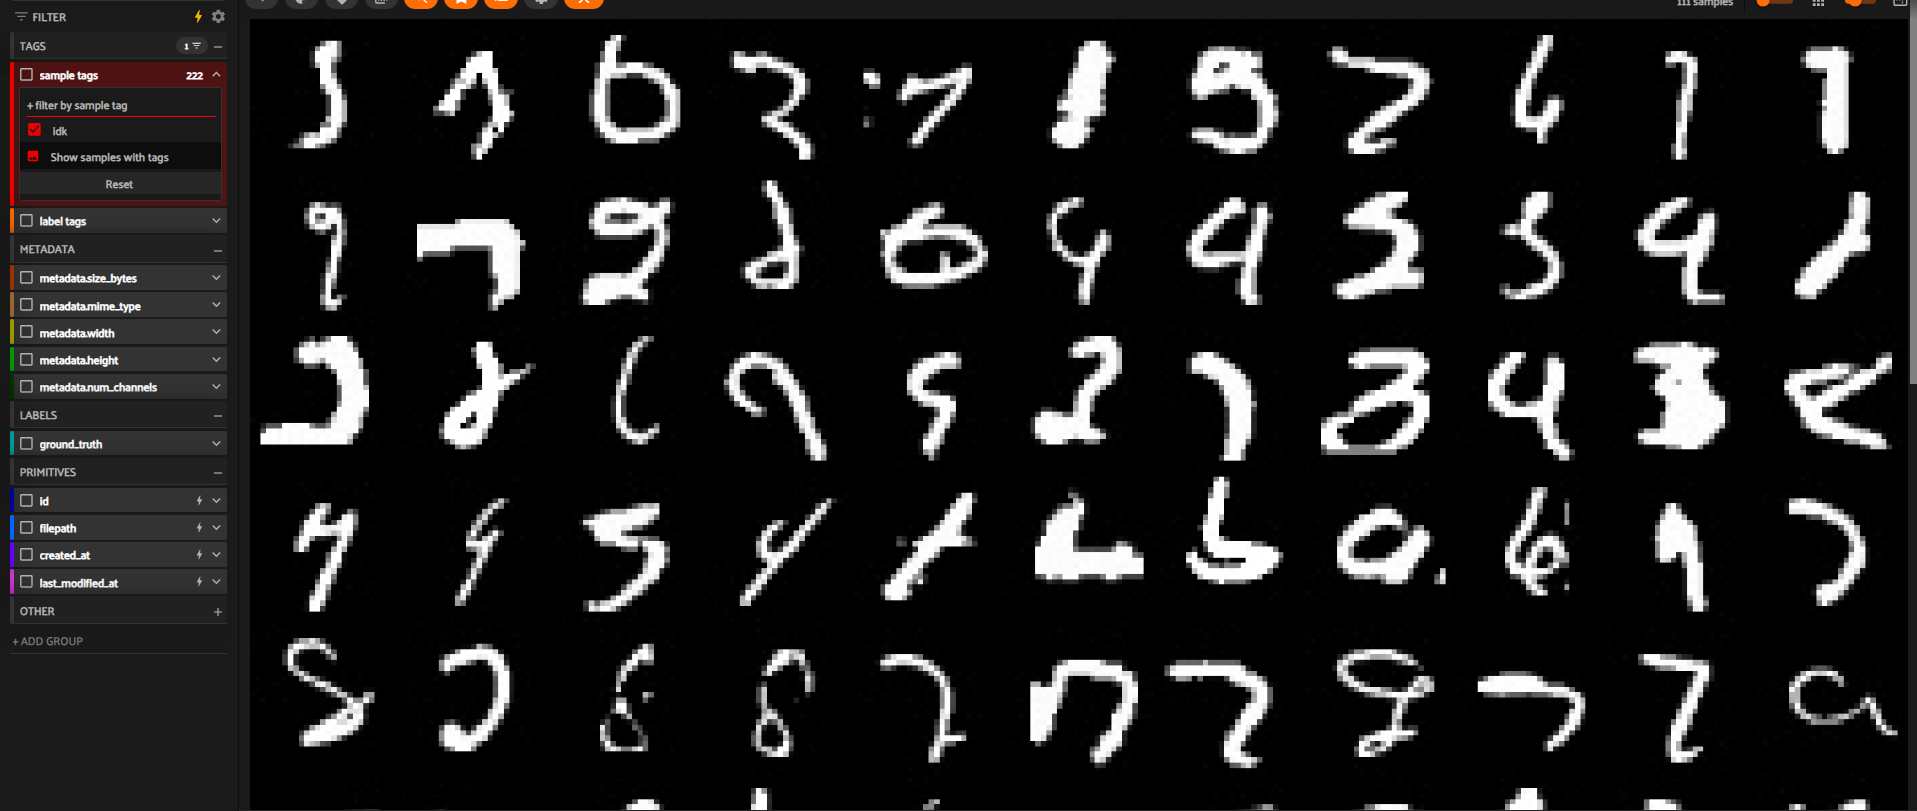

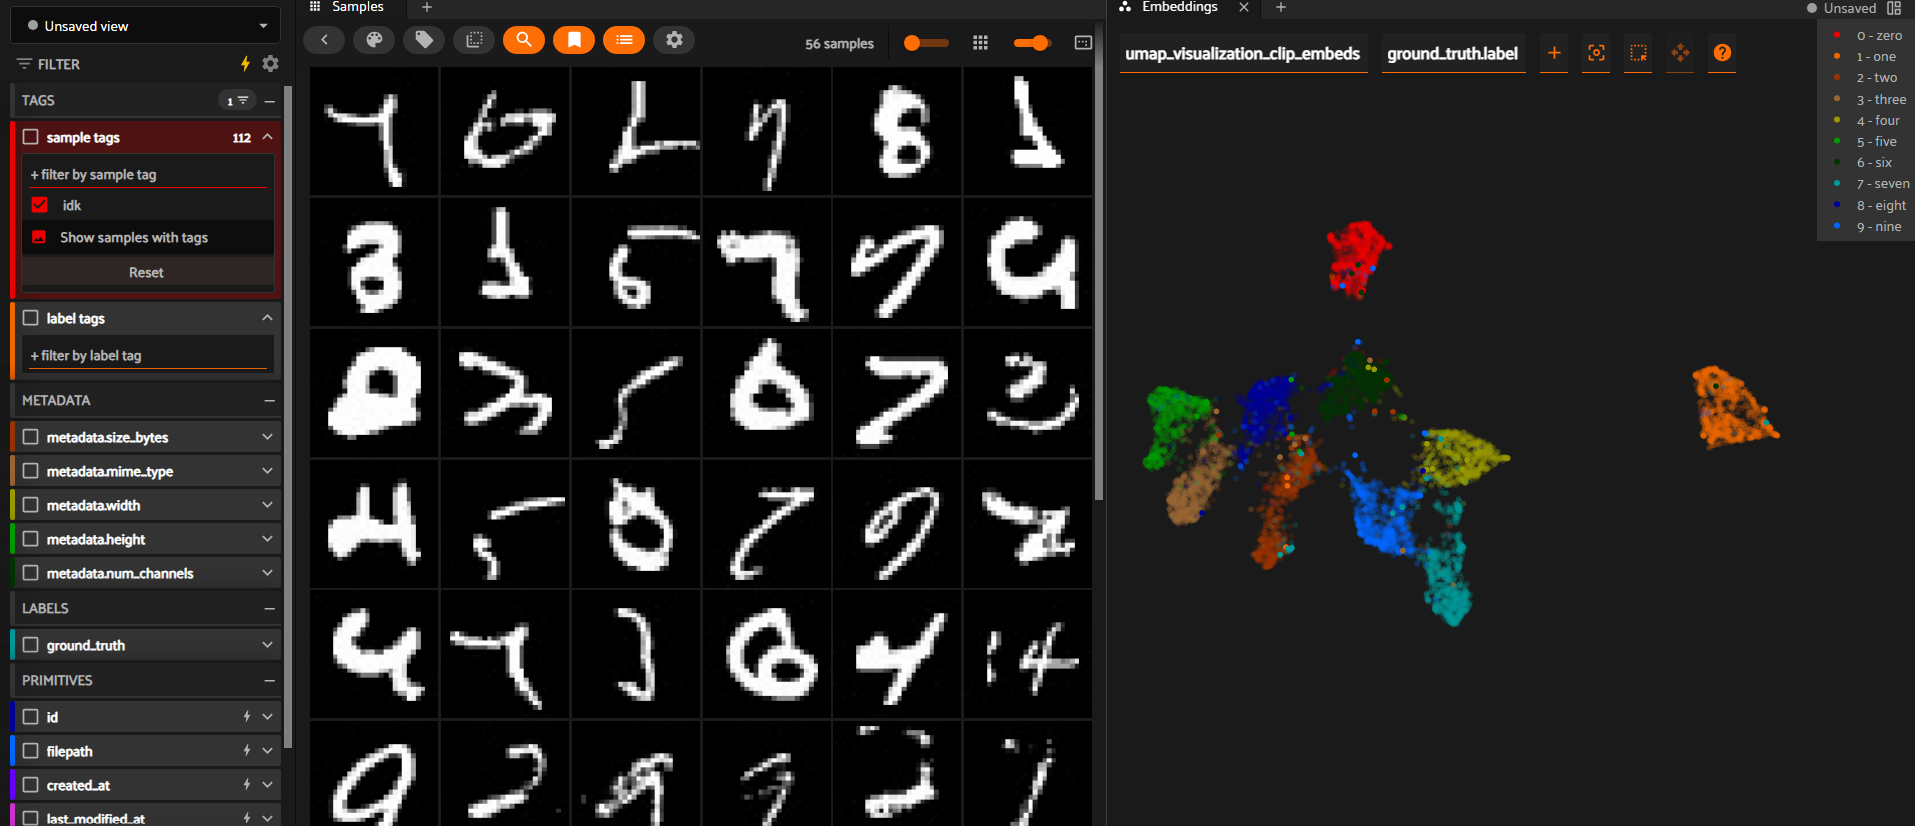


We select all samples where it is not clear which number it is or with weird . I was quite lenient with selecting idk samples - for some it is clearer what it should be than for others.

In [15]:
train_clip_pca_umap_idk_outliers = [
    "/root/fiftyone/mnist/train/data/000133.jpg",
    "/root/fiftyone/mnist/train/data/000341.jpg",
    "/root/fiftyone/mnist/train/data/000495.jpg",
    "/root/fiftyone/mnist/train/data/000501.jpg",
    "/root/fiftyone/mnist/train/data/000934.jpg",
    "/root/fiftyone/mnist/train/data/001288.jpg",
    "/root/fiftyone/mnist/train/data/001357.jpg",
    "/root/fiftyone/mnist/train/data/002577.jpg",
    "/root/fiftyone/mnist/train/data/003230.jpg",
    "/root/fiftyone/mnist/train/data/003533.jpg",
    "/root/fiftyone/mnist/train/data/003693.jpg",
    "/root/fiftyone/mnist/train/data/003697.jpg",
    "/root/fiftyone/mnist/train/data/004227.jpg",
    "/root/fiftyone/mnist/train/data/005014.jpg",
    "/root/fiftyone/mnist/train/data/005111.jpg",
    "/root/fiftyone/mnist/train/data/005195.jpg",
    "/root/fiftyone/mnist/train/data/005705.jpg",
    "/root/fiftyone/mnist/train/data/006093.jpg",
    "/root/fiftyone/mnist/train/data/007006.jpg",
    "/root/fiftyone/mnist/train/data/007585.jpg",
    "/root/fiftyone/mnist/train/data/008469.jpg",
    "/root/fiftyone/mnist/train/data/008481.jpg",
    "/root/fiftyone/mnist/train/data/008618.jpg",
    "/root/fiftyone/mnist/train/data/008671.jpg",
    "/root/fiftyone/mnist/train/data/009535.jpg",
    "/root/fiftyone/mnist/train/data/010525.jpg",
    "/root/fiftyone/mnist/train/data/010945.jpg",
    "/root/fiftyone/mnist/train/data/012184.jpg",
    "/root/fiftyone/mnist/train/data/014247.jpg",
    "/root/fiftyone/mnist/train/data/014284.jpg",
    "/root/fiftyone/mnist/train/data/014583.jpg",
    "/root/fiftyone/mnist/train/data/014693.jpg",
    "/root/fiftyone/mnist/train/data/014897.jpg",
    "/root/fiftyone/mnist/train/data/014962.jpg",
    "/root/fiftyone/mnist/train/data/015729.jpg",
    "/root/fiftyone/mnist/train/data/016679.jpg",
    "/root/fiftyone/mnist/train/data/016866.jpg",
    "/root/fiftyone/mnist/train/data/017210.jpg",
    "/root/fiftyone/mnist/train/data/017729.jpg",
    "/root/fiftyone/mnist/train/data/018303.jpg",
    "/root/fiftyone/mnist/train/data/018406.jpg",
    "/root/fiftyone/mnist/train/data/018606.jpg",
    "/root/fiftyone/mnist/train/data/019413.jpg",
    "/root/fiftyone/mnist/train/data/024831.jpg",
    "/root/fiftyone/mnist/train/data/025547.jpg",
    "/root/fiftyone/mnist/train/data/025995.jpg",
    "/root/fiftyone/mnist/train/data/026472.jpg",
    "/root/fiftyone/mnist/train/data/026516.jpg",
    "/root/fiftyone/mnist/train/data/026627.jpg",
    "/root/fiftyone/mnist/train/data/026883.jpg",
    "/root/fiftyone/mnist/train/data/027723.jpg",
    "/root/fiftyone/mnist/train/data/028369.jpg",
    "/root/fiftyone/mnist/train/data/028633.jpg",
    "/root/fiftyone/mnist/train/data/028957.jpg",
    "/root/fiftyone/mnist/train/data/028985.jpg",
    "/root/fiftyone/mnist/train/data/030050.jpg",
    "/root/fiftyone/mnist/train/data/030605.jpg",
    "/root/fiftyone/mnist/train/data/031597.jpg",
    "/root/fiftyone/mnist/train/data/033319.jpg",
    "/root/fiftyone/mnist/train/data/033507.jpg",
    "/root/fiftyone/mnist/train/data/037901.jpg",
    "/root/fiftyone/mnist/train/data/039422.jpg",
    "/root/fiftyone/mnist/train/data/039424.jpg",
    "/root/fiftyone/mnist/train/data/040035.jpg",
    "/root/fiftyone/mnist/train/data/040655.jpg",
    "/root/fiftyone/mnist/train/data/040977.jpg",
    "/root/fiftyone/mnist/train/data/041055.jpg",
    "/root/fiftyone/mnist/train/data/041073.jpg",
    "/root/fiftyone/mnist/train/data/041200.jpg",
    "/root/fiftyone/mnist/train/data/041425.jpg",
    "/root/fiftyone/mnist/train/data/042658.jpg",
    "/root/fiftyone/mnist/train/data/043545.jpg",
    "/root/fiftyone/mnist/train/data/043576.jpg",
    "/root/fiftyone/mnist/train/data/046436.jpg",
    "/root/fiftyone/mnist/train/data/047245.jpg",
    "/root/fiftyone/mnist/train/data/047601.jpg",
    "/root/fiftyone/mnist/train/data/047690.jpg",
    "/root/fiftyone/mnist/train/data/047927.jpg",
    "/root/fiftyone/mnist/train/data/048487.jpg",
    "/root/fiftyone/mnist/train/data/048639.jpg",
    "/root/fiftyone/mnist/train/data/049290.jpg",
    "/root/fiftyone/mnist/train/data/050418.jpg",
    "/root/fiftyone/mnist/train/data/050521.jpg",
    "/root/fiftyone/mnist/train/data/050573.jpg",
    "/root/fiftyone/mnist/train/data/050725.jpg",
    "/root/fiftyone/mnist/train/data/051577.jpg",
    "/root/fiftyone/mnist/train/data/051945.jpg",
    "/root/fiftyone/mnist/train/data/052170.jpg",
    "/root/fiftyone/mnist/train/data/052254.jpg",
    "/root/fiftyone/mnist/train/data/052274.jpg",
    "/root/fiftyone/mnist/train/data/052276.jpg",
    "/root/fiftyone/mnist/train/data/052601.jpg",
    "/root/fiftyone/mnist/train/data/052915.jpg",
    "/root/fiftyone/mnist/train/data/052933.jpg",
    "/root/fiftyone/mnist/train/data/053217.jpg",
    "/root/fiftyone/mnist/train/data/053807.jpg",
    "/root/fiftyone/mnist/train/data/054050.jpg",
    "/root/fiftyone/mnist/train/data/054197.jpg",
    "/root/fiftyone/mnist/train/data/054343.jpg",
    "/root/fiftyone/mnist/train/data/055491.jpg",
    "/root/fiftyone/mnist/train/data/055755.jpg",
    "/root/fiftyone/mnist/train/data/056211.jpg",
    "/root/fiftyone/mnist/train/data/056453.jpg",
    "/root/fiftyone/mnist/train/data/056597.jpg",
    "/root/fiftyone/mnist/train/data/057077.jpg",
    "/root/fiftyone/mnist/train/data/057631.jpg",
    "/root/fiftyone/mnist/train/data/057745.jpg",
    "/root/fiftyone/mnist/train/data/059717.jpg",
    "/root/fiftyone/mnist/train/data/059721.jpg",
    "/root/fiftyone/mnist/train/data/059725.jpg",
    "/root/fiftyone/mnist/train/data/059916.jpg",
]
for s in train_dataset:
    if s['filepath'] in train_clip_pca_umap_idk_outliers:
      s.tags.append('idk')
      s.save()

In [16]:
val_clip_pca_umap_idk_outliers = [
    "/root/fiftyone/mnist/train/data/004150.jpg",
    "/root/fiftyone/mnist/train/data/005843.jpg",
    "/root/fiftyone/mnist/train/data/005973.jpg",
    "/root/fiftyone/mnist/train/data/008208.jpg",
    "/root/fiftyone/mnist/train/data/008224.jpg",
    "/root/fiftyone/mnist/train/data/008385.jpg",
    "/root/fiftyone/mnist/train/data/010033.jpg",
    "/root/fiftyone/mnist/train/data/010218.jpg",
    "/root/fiftyone/mnist/train/data/010339.jpg",
    "/root/fiftyone/mnist/train/data/011760.jpg",
    "/root/fiftyone/mnist/train/data/012376.jpg",
    "/root/fiftyone/mnist/train/data/012792.jpg",
    "/root/fiftyone/mnist/train/data/012837.jpg",
    "/root/fiftyone/mnist/train/data/015244.jpg",
    "/root/fiftyone/mnist/train/data/017075.jpg",
    "/root/fiftyone/mnist/train/data/017214.jpg",
    "/root/fiftyone/mnist/train/data/017244.jpg",
    "/root/fiftyone/mnist/train/data/017818.jpg",
    "/root/fiftyone/mnist/train/data/018067.jpg",
    "/root/fiftyone/mnist/train/data/024588.jpg",
    "/root/fiftyone/mnist/train/data/026018.jpg",
    "/root/fiftyone/mnist/train/data/026623.jpg",
    "/root/fiftyone/mnist/train/data/027223.jpg",
    "/root/fiftyone/mnist/train/data/028067.jpg",
    "/root/fiftyone/mnist/train/data/028711.jpg",
    "/root/fiftyone/mnist/train/data/030494.jpg",
    "/root/fiftyone/mnist/train/data/031807.jpg",
    "/root/fiftyone/mnist/train/data/032343.jpg",
    "/root/fiftyone/mnist/train/data/033305.jpg",
    "/root/fiftyone/mnist/train/data/033363.jpg",
    "/root/fiftyone/mnist/train/data/036223.jpg",
    "/root/fiftyone/mnist/train/data/043659.jpg",
    "/root/fiftyone/mnist/train/data/046249.jpg",
    "/root/fiftyone/mnist/train/data/046829.jpg",
    "/root/fiftyone/mnist/train/data/047161.jpg",
    "/root/fiftyone/mnist/train/data/048776.jpg",
    "/root/fiftyone/mnist/train/data/048976.jpg",
    "/root/fiftyone/mnist/train/data/050330.jpg",
    "/root/fiftyone/mnist/train/data/050523.jpg",
    "/root/fiftyone/mnist/train/data/051249.jpg",
    "/root/fiftyone/mnist/train/data/053064.jpg",
    "/root/fiftyone/mnist/train/data/053397.jpg",
    "/root/fiftyone/mnist/train/data/053855.jpg",
    "/root/fiftyone/mnist/train/data/054757.jpg",
    "/root/fiftyone/mnist/train/data/056867.jpg",
    "/root/fiftyone/mnist/train/data/058317.jpg",
    "/root/fiftyone/mnist/train/data/059702.jpg",
    "/root/fiftyone/mnist/train/data/059748.jpg",
]
for s in val_dataset:
    if s['filepath'] in val_clip_pca_umap_idk_outliers:
      s.tags.append('idk')
      s.save()

In [17]:
test_clip_pca_umap_idk_outliers = [
    "/root/fiftyone/mnist/test/data/000359.jpg",
    "/root/fiftyone/mnist/test/data/000446.jpg",
    "/root/fiftyone/mnist/test/data/000647.jpg",
    "/root/fiftyone/mnist/test/data/000690.jpg",
    "/root/fiftyone/mnist/test/data/000937.jpg",
    "/root/fiftyone/mnist/test/data/000957.jpg",
    "/root/fiftyone/mnist/test/data/001115.jpg",
    "/root/fiftyone/mnist/test/data/001528.jpg",
    "/root/fiftyone/mnist/test/data/001912.jpg",
    "/root/fiftyone/mnist/test/data/002049.jpg",
    "/root/fiftyone/mnist/test/data/002269.jpg",
    "/root/fiftyone/mnist/test/data/002294.jpg",
    "/root/fiftyone/mnist/test/data/002463.jpg",
    "/root/fiftyone/mnist/test/data/002928.jpg",
    "/root/fiftyone/mnist/test/data/002931.jpg",
    "/root/fiftyone/mnist/test/data/003423.jpg",
    "/root/fiftyone/mnist/test/data/003442.jpg",
    "/root/fiftyone/mnist/test/data/003449.jpg",
    "/root/fiftyone/mnist/test/data/003543.jpg",
    "/root/fiftyone/mnist/test/data/003553.jpg",
    "/root/fiftyone/mnist/test/data/003559.jpg",
    "/root/fiftyone/mnist/test/data/003809.jpg",
    "/root/fiftyone/mnist/test/data/004164.jpg",
    "/root/fiftyone/mnist/test/data/004177.jpg",
    "/root/fiftyone/mnist/test/data/004224.jpg",
    "/root/fiftyone/mnist/test/data/004401.jpg",
    "/root/fiftyone/mnist/test/data/004444.jpg",
    "/root/fiftyone/mnist/test/data/004572.jpg",
    "/root/fiftyone/mnist/test/data/005083.jpg",
    "/root/fiftyone/mnist/test/data/005677.jpg",
    "/root/fiftyone/mnist/test/data/006506.jpg",
    "/root/fiftyone/mnist/test/data/006555.jpg",
    "/root/fiftyone/mnist/test/data/006561.jpg",
    "/root/fiftyone/mnist/test/data/006572.jpg",
    "/root/fiftyone/mnist/test/data/006575.jpg",
    "/root/fiftyone/mnist/test/data/006577.jpg",
    "/root/fiftyone/mnist/test/data/006585.jpg",
    "/root/fiftyone/mnist/test/data/006608.jpg",
    "/root/fiftyone/mnist/test/data/007217.jpg",
    "/root/fiftyone/mnist/test/data/007473.jpg",
    "/root/fiftyone/mnist/test/data/007561.jpg",
    "/root/fiftyone/mnist/test/data/007566.jpg",
    "/root/fiftyone/mnist/test/data/007575.jpg",
    "/root/fiftyone/mnist/test/data/007842.jpg",
    "/root/fiftyone/mnist/test/data/008001.jpg",
    "/root/fiftyone/mnist/test/data/008280.jpg",
    "/root/fiftyone/mnist/test/data/008317.jpg",
    "/root/fiftyone/mnist/test/data/009506.jpg",
    "/root/fiftyone/mnist/test/data/009541.jpg",
    "/root/fiftyone/mnist/test/data/009635.jpg",
    "/root/fiftyone/mnist/test/data/009643.jpg",
    "/root/fiftyone/mnist/test/data/009699.jpg",
    "/root/fiftyone/mnist/test/data/009755.jpg",
    "/root/fiftyone/mnist/test/data/009763.jpg",
    "/root/fiftyone/mnist/test/data/009771.jpg",
    "/root/fiftyone/mnist/test/data/009778.jpg",
]
for s in test_dataset:
    if s['filepath'] in test_clip_pca_umap_idk_outliers:
      s.tags.append('idk')
      s.save()

## Moving the FiftyOne Data Splits to torch Datasets

To train our PyTorch model, we need to convert our FiftyOne dataset views into PyTorch `Dataset` objects that can load and preprocess images during training. This bridge between FiftyOne's dataset management and PyTorch's training pipeline is important for maintaining both the metadata and annotations while enabling batch processing. PyTorch's `Dataset` class provides a standardized interface for data loading, handling tasks like image loading, preprocessing transforms, and label conversion. By creating a custom dataset class that works with FiftyOne's file paths and labels, we can leverage PyTorch's `DataLoader` for batching, shuffling, and parallel data loading while preserving all the dataset analysis capabilities that FiftyOne provides. This approach allows us to move between FiftyOne's visual analysis and PyTorch's training workflows without duplicating data or losing the rich metadata we've computed.

In [18]:
# Custom PyTorch Dataset class for MNIST training data
class CustomTorchImageDataset(torch.utils.data.Dataset):
    def __init__(self, fiftyone_dataset,
                 image_transforms=None,
                 label_map=None,
                 gt_field="ground_truth"):
        self.fiftyone_dataset = fiftyone_dataset
        self.image_paths = self.fiftyone_dataset.values("filepath")
        self.str_labels = self.fiftyone_dataset.values(f"{gt_field}.label")
        self.image_transforms = image_transforms

        if label_map is None:
            self.label_map = {str(i): i for i in range(10)}  # "0"->0, "1"->1, etc.
        else:
            self.label_map = label_map

        print(f"CustomTorchImageDataset initialized with {len(self.image_paths)} samples.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        try:
            image = Image.open(image_path).convert('L')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return torch.randn(1, 28, 28), torch.tensor(-1, dtype=torch.long)

        if self.image_transforms:
            image = self.image_transforms(image)

        label_str = self.str_labels[idx]
        label_idx = self.label_map.get(label_str, -1)
        if label_idx == -1:
            print(f"Warning: Label '{label_str}' not in label_map for image {image_path}")

        return image, torch.tensor(label_idx, dtype=torch.long)

## Computing the Mean and Standard Deviation

Before training neural networks, we compute the **mean and standard deviation** of our input data to apply **standard scaling** (also called normalization or standardization).


**Standard Scaling Formula:**

$$z = \frac{x - \mu}{\sigma}$$

Where:
- $z$ = standardized value
- $x$ = original pixel value
- $\mu$ = mean of all pixel values in the dataset
- $\sigma$ = standard deviation of all pixel values in the dataset

In PyTorch, this is implemented with torch.`transforms.Normalize((mean_intensity), (std_intensity))`

This preprocessing step transforms our pixel values to have zero mean and unit variance, which provides several critical benefits:

**Why Standard Scaling Matters:**

**Gradient Optimization**: Neural networks learn through gradient descent, which works best when input features are on similar scales. Without scaling, features with larger magnitudes (like raw pixel values 0-255) can dominate the gradient updates, leading to slower convergence and unstable training.

**Weight Initialization Compatibility**: Modern weight initialization schemes (Xavier, He initialization) assume inputs are roughly centered around zero with unit variance. Standard scaling ensures our data matches these assumptions, preventing vanishing or exploding gradients during early training.

**Activation Function Efficiency**: Many activation functions (tanh, sigmoid) work optimally when inputs are centered around zero. Scaled inputs help neurons operate in the most responsive regions of these functions rather than saturating in flat regions.

**Learning Rate Stability**: With standardized inputs, we can use higher learning rates without instability, as the optimization landscape becomes more uniform across different dimensions.

For MNIST images, we transform raw pixel values from the range [0, 255] to approximately [-1, 1] with mean ≈ 0, creating a more favorable training environment that typically results in faster convergence and better final performance.


In [19]:
def compute_stats_fiftyone(fiftyone_view):
    """
    Compute stats directly from FiftyOne using aggregations.
    Requires images to be loaded as arrays.
    """

    print("Computing image intensity statistics from FiftyOne view...")

    # Get all image filepaths
    filepaths = fiftyone_view.values("filepath")

    # Load all pixel values
    all_pixels = []

    for filepath in tqdm(filepaths):

        try:
            # Load image as grayscale array
            image = Image.open(filepath).convert('L')
            # Scale values to the range [0, 1]
            pixels = np.array(image, dtype=np.float32) / 255.0
            all_pixels.append(pixels.flatten())
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
            continue

    # Concatenate all pixel values
    all_pixels = np.concatenate(all_pixels)

    # Compute statistics
    mean = np.mean(all_pixels)
    std = np.std(all_pixels)

    print(f"Computed from {len(filepaths)} images")
    print(f"Total pixels: {len(all_pixels):,}")

    return mean, std

mean_intensity, std_intensity = compute_stats_fiftyone(train_dataset)
f"Mean: {mean_intensity:.4f}, Std: {std_intensity:.4f}"

Computing image intensity statistics from FiftyOne view...


100%|██████████| 51000/51000 [00:07<00:00, 6908.41it/s]


Computed from 51000 images
Total pixels: 39,984,000


'Mean: 0.1318, Std: 0.3075'

In [20]:
# We obtain the distinct labels of the dataset
dataset_classes = sorted(train_dataset.distinct("ground_truth.label"))
dataset_classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [21]:
# Map the string labels to numerical values (we need this for the PyTorch dataset)
label_map = {string_label: index for index, string_label in enumerate(dataset_classes)}
label_map

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

Transform the PIL images into PyTorch tensors with scaling based on stats from the training set.

In [22]:
image_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize((mean_intensity,), (std_intensity,))
])

In [54]:
torch_train_set = CustomTorchImageDataset(train_dataset,
                                          label_map=label_map,
                                          image_transforms=image_transforms)

CustomTorchImageDataset initialized with 51000 samples.


In [55]:
torch_val_set = CustomTorchImageDataset(val_dataset,
                                     label_map=label_map,
                                     image_transforms=image_transforms)

CustomTorchImageDataset initialized with 9000 samples.


In [56]:
# Create a PyTorch Dataset for the test set
torch_test_set = CustomTorchImageDataset(test_dataset,
                                      label_map=label_map, # Use the same label map as training
                                      image_transforms=image_transforms) # Use the same transforms

CustomTorchImageDataset initialized with 10000 samples.


### Create PyTorch DataLoaders

DataLoaders wrap our custom datasets and handle the mechanics of training: batching samples together, shuffling data between epochs, and loading images in parallel using multiple CPU cores. The batch size determines how many images the model processes at once, affecting both memory usage and training dynamics. We shuffle the training data to prevent the model from learning spurious patterns based on sample order, but keep validation data unshuffled since evaluation order doesn't matter. Parallel loading with multiple workers speeds up training by preparing the next batch while the GPU processes the current one.



In [57]:
# Define batch size (you can adjust this based on your GPU memory)
batch_size = 64
num_workers = os.cpu_count()  # Number of CPU cores

In [58]:
train_loader = create_deterministic_training_dataloader(
    torch_train_set,
    batch_size=64,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

In [59]:
val_loader = torch.utils.data.DataLoader(
    torch_val_set,
    batch_size=batch_size,
    shuffle=False, # No need to shuffle validation data
    num_workers=num_workers,
    pin_memory=True
)

In [60]:
test_loader = torch.utils.data.DataLoader(
    torch_test_set,
    batch_size=batch_size,
    shuffle=False, # No need to shuffle test data
    num_workers=num_workers,
    pin_memory=True
)

In [61]:
print("Train and validation DataLoaders created successfully.")
print(f"Train DataLoader has {len(train_loader)} batches.")
print(f"Validation DataLoader has {len(val_loader)} batches.")
print(f"Test DataLoader has {len(test_loader)} batches.")

Train and validation DataLoaders created successfully.
Train DataLoader has 797 batches.
Validation DataLoader has 141 batches.
Test DataLoader has 157 batches.


## Instantiate the Loss Function (Categorical Cross Entropy)

**Categorical Cross Entropy** is the standard loss function for multi-class classification problems like MNIST digit recognition. It measures how far our model's predicted probability distribution is from the true distribution (one-hot encoded labels).

**Mathematical Formula:**
$$\text{CCE} = -\sum_{i=1}^{C} y_i \log(\hat{y}_i)$$

Where:
- $C$ = number of classes (10 for MNIST digits 0-9)
- $y_i$ = true label (1 for correct class, 0 for others)
- $\hat{y}_i$ = predicted probability for class $i$

**Intuitions about Cross Entropy Loss**: The loss encourages the model to output high confidence (probability close to 1.0) for the correct class and low confidence for incorrect classes.

For a perfectly correct prediction (probability = 1.0 for true class), the loss approaches 0 and gradients are small (meaning that there is little change on weights). For very wrong predictions (probability = 0.001 for the ground truth class), the loss approaches infinity, strongly penalizing confident mistakes and forcing the neural network to update its weights.

PyTorch implements a numerically stable variant of CCE based on the LogSoftMax function. You can read more about it [here](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [23]:
ce_loss = nn.CrossEntropyLoss()

## Prepare Training and Validation for our Custom Model

We define two functions to handle the training and validation phases of each epoch. The `train_epoch()` function puts the model in training mode, processes batches through forward passes, computes loss, and updates weights via backpropagation.

In [24]:
def train_epoch(model, train_loader):
  batch_losses = []
  model.train()
  for images, labels in tqdm(train_loader, desc="Training: "):
      #import pdb; pdb.set_trace()

      images = images.to(device)
      labels = labels.to(device)
      # Forward pass
      logits = model(images)
      loss_value = ce_loss(logits, labels)
      # Clear gradients from previous iteration (PyTorch accumulates by default)
      optimizer.zero_grad()
      # Computes the gradients with backpropagation
      loss_value.backward()
      # Updates the weights
      optimizer.step()

      batch_losses.append(loss_value.item())

  train_loss = np.mean(batch_losses)
  return train_loss


The `val_epoch()` function switches the model to evaluation mode and computes validation loss without updating weights, giving us an unbiased measure of performance on held-out data. These functions return the average loss across all batches, which we'll track to monitor training progress and detect overfitting.

In [25]:
def val_epoch(model, val_loader):
  batch_losses = []
  model.eval()
  with torch.inference_mode():
    for images, labels in tqdm(val_loader, desc="Validation: "):
      images = images.to(device)
      labels = labels.to(device)
      # Forward pass
      logits = model(images)
      loss_value = ce_loss(logits, labels)
      batch_losses.append(loss_value.item())
  val_loss = np.mean(batch_losses)
  return val_loss

## Defining the Optimizer

**Configuring the Learning Algorithm**

The optimizer determines how the neural network updates its weights based on computed gradients during training. This choice affects training speed, stability, and final model performance.

**Adam (Adaptive Moment Estimation)** is a variant of gradient descent that maintains running averages of both gradients and their squared values, allowing us to adapt the learning rate based on the historical behavior of each weight.

```python
optimizer = Adam(model.parameters(),
                 lr=0.003, betas=(0.9, 0.999),
                 eps=1e-08, weight_decay=0)
```

The learning rate (lr=0.003) controls the step size for weight updates, while the beta settings control how much history to consider when computing the adaptive rates. This configuration provides stable training for most computer vision tasks.


In [ ]:
model = ModernLeNet5().to(device)

# Define the optimizer (variant of stochastic gradient descent)
optimizer = Adam(model.parameters(),
                 lr=0.003, betas=(0.9, 0.999),
                 eps=1e-08, weight_decay=0)


## Training and Checkpointing the Model

**Iterative Learning with Performance Monitoring**

Training a neural network involves showing the model batches of data, computing prediction errors, and updating weights to minimize those errors. This process continues for multiple epochs, where each epoch represents one complete pass through the entire training dataset.

**The Role of Validation-Based Checkpointing**

During training, we monitor performance on both training and validation sets. Training loss decreases as the model learns, but validation loss reveals the true generalization capability. The validation set acts as a proxy for real-world performance since the model never sees these samples during weight updates.

We save model checkpoints based on validation performance rather than training performance to prevent overfitting. A model might achieve low training loss by memorizing training examples, but this doesn't guarantee good performance on new data. By saving the model weights that achieve the best validation loss, we capture the point where the model has learned generalizable patterns without overfitting to training-specific details.

```python
if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_model = model
    torch.save(best_model.state_dict(), model_save_path)
    print('Found and saved better weights for the model')
```

This checkpointing strategy ensures we retain the model configuration that will perform best on unseen test data, even if training continues and validation performance later degrades due to overfitting.

In [66]:
# Ensure reproducibility for the training process
set_seeds(99) # You can change this number to get different results

num_epochs = 10
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model = None

# Define the path to save the model within your hard-drive
path = Path(os.getcwd()) # Feel free to change the path

model_save_path = path / 'best_lenet.pth'

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader)
    val_loss = val_epoch(model, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)


    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        # Save the best model
        torch.save(best_model.state_dict(), model_save_path)
        print('Found and saved better weights for the model')

All random seeds set to 99 for reproducibility


Validation: 100%|██████████| 141/141 [00:03<00:00, 37.87it/s]


Epoch 1/10 - Train Loss: 0.2348 - Val Loss: 0.0818
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:05<00:00, 25.49it/s]


Epoch 2/10 - Train Loss: 0.0903 - Val Loss: 0.0722
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:08<00:00, 15.90it/s]


Epoch 3/10 - Train Loss: 0.0700 - Val Loss: 0.0508
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:05<00:00, 25.04it/s]


Epoch 4/10 - Train Loss: 0.0593 - Val Loss: 0.0592


Validation: 100%|██████████| 141/141 [00:04<00:00, 34.41it/s]


Epoch 5/10 - Train Loss: 0.0536 - Val Loss: 0.0530


Validation: 100%|██████████| 141/141 [00:03<00:00, 42.06it/s]


Epoch 6/10 - Train Loss: 0.0483 - Val Loss: 0.0733


Validation: 100%|██████████| 141/141 [00:03<00:00, 42.16it/s]


Epoch 7/10 - Train Loss: 0.0445 - Val Loss: 0.0718


Validation: 100%|██████████| 141/141 [00:03<00:00, 41.60it/s]


Epoch 8/10 - Train Loss: 0.0398 - Val Loss: 0.0944


Validation: 100%|██████████| 141/141 [00:05<00:00, 27.46it/s]


Epoch 9/10 - Train Loss: 0.0366 - Val Loss: 0.0609


Validation: 100%|██████████| 141/141 [00:04<00:00, 30.70it/s]

Epoch 10/10 - Train Loss: 0.0403 - Val Loss: 0.0857


## Visualizing Training vs Validation Losses

Plotting training and validation loss over epochs provides insights into model learning dynamics. These curves reveal whether the model is learning, overfitting, or underfitting the data.
In healthy training, both curves decrease together, with training loss lower than validation loss. When training loss continues decreasing while validation loss plateaus or increases, this indicates overfitting where the model memorizes training data rather than learning generalizable patterns. If both curves plateau at high values, the model may be underfitting and require more capacity (e.g.more layers or more weights) or more training epochs.

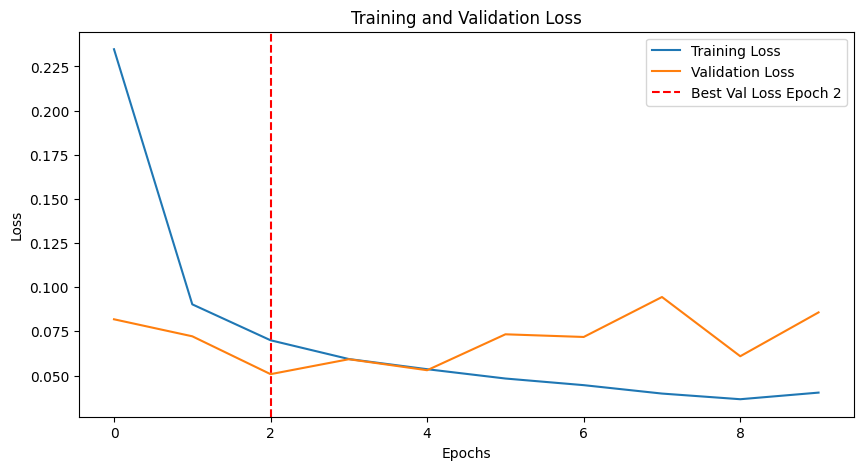

In [67]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Find the epoch with the best validation loss
best_epoch = np.argmin(val_losses)

# Add a vertical red line at the epoch with the best validation loss
plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Val Loss Epoch {best_epoch}')
plt.legend()

plt.show()

## Reload the Best LeNet Model Weights

After training completes, we need to load the saved model weights that achieved the best validation performance. This ensures we use the model configuration that generalizes best to unseen data, rather than the final training state which may have overfitted.
The reloading process involves creating a new model instance with the same architecture, then loading the saved state dictionary containing the optimal weights. We must ensure the model is moved to the correct device (CPU or GPU) and set to evaluation mode for inference.

In [68]:
# Define the path where the best model was saved
path = Path(os.getcwd())
model_save_path = path / 'best_lenet.pth'

# Instantiate a new model with the same architecture
# Make sure you use the same model class that was trained
loaded_model = ModernLeNet5()

# Load the saved state dictionary into the new model instance
# Make sure the model is on the correct device (CPU or GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_model.load_state_dict(torch.load(model_save_path, map_location=device))

# Move the model to the device
loaded_model = loaded_model.to(device)

# Set the model to evaluation mode
loaded_model.eval()

print(f"Model loaded successfully from {model_save_path}")
print(f"Model is on device: {next(loaded_model.parameters()).device}")

Model loaded successfully from /content/best_lenet.pth
Model is on device: cuda:0


## Apply our Custom Model to the Test Set

We have trained our LeNet-5 model and need to apply it to the test set to generate predictions and evaluate its performance. This step bridges the gap between PyTorch training and FiftyOne's analysis capabilities.

**Why Store Predictions as FiftyOne Classifications?**

Instead of storing raw predictions as strings or numbers, we use FiftyOne's [`Classification`](https://docs.voxel51.com/api/fiftyone.core.labels.html#fiftyone.core.labels.Classification) objects, which provide several key advantages:

**Structured Data Storage**: Classification objects encapsulate the predicted label, confidence score, and raw logits in a standardized format that FiftyOne understands.

**Evaluation Integration**: FiftyOne's evaluation framework (`evaluate_classifications()`) can compare Classification objects against ground truth labels, generating metrics like confusion matrices, per-class accuracy, and performance reports.

**Querying and Filtering**: With Classification objects, we can filter samples by confidence thresholds, find misclassifications, or identify uncertain predictions using FiftyOne's query language:

```python
# Find high-confidence predictions
high_conf = dataset.match(F("predictions.confidence") > 0.95)

# Find misclassifications  
errors = dataset.match(F("predictions.label") != F("ground_truth.label"))
```

**Visual Analysis**: The FiftyOne App can visualize Classification objects with confidence scores, making it simple to spot patterns in model behavior and identify errors.

**Model Comparison**: Storing predictions in this standardized format enables comparison between different models (like our LeNet vs. CLIP's zero-shot classification) using the same evaluation framework.

**Confidence-Based Analysis**: The embedded confidence scores allow for analysis like identifying samples where the model is uncertain, which correspond to edge cases or potential labeling errors in the dataset.

This approach transforms raw model outputs into queryable metadata that integrates with FiftyOne's computer vision workflow, enabling insights into model performance and behavior.

In [69]:
## Apply best_model to the test set, store logits and confidence

print(f"Test DataLoader has {len(test_loader)} batches.")

# Set the loaded model to evaluation mode
loaded_model.eval()

# Lists to store predictions and logits
predictions = []
all_logits = []

# Run inference on the test set
print("Applying best LeNet model to the test set...")
with torch.inference_mode(): # Disable gradient calculation
    for images, _ in tqdm(test_loader):
        images = images.to(device)

        # Forward pass to get logits
        logits = loaded_model(images)
        all_logits.append(logits.cpu().numpy()) # Store logits

        # Get predicted class indices
        _, predicted = torch.max(logits.data, 1)
        predictions.extend(predicted.cpu().numpy()) # Store predictions

# Concatenate logits from all batches
all_logits = np.concatenate(all_logits, axis=0)

print("Inference on test set complete.")
print(f"Shape of collected logits: {all_logits.shape}")
print(f"Number of collected predictions: {len(predictions)}")

# Store the predictions and logits back into the FiftyOne dataset as Classification objects
print("Storing predictions and logits as FiftyOne Classifications...")

for i, sample in enumerate(test_dataset):
    # Get the predicted class index and corresponding class name
    predicted_idx = predictions[i]
    predicted_label = dataset_classes[predicted_idx]

    # Get logits for this sample
    sample_logits = all_logits[i]

    # Calculate confidence scores (softmax applied to logits)
    confidences = Fun.softmax(torch.tensor(sample_logits), dim=0).numpy()
    predicted_confidence = float(confidences[predicted_idx])

    # Create FiftyOne Classification object with prediction
    classification = fo.Classification(
        label=predicted_label,
        confidence=predicted_confidence,
        logits=sample_logits.tolist()  # Store raw logits
    )

    # Store the Classification object in the sample
    sample["lenet_classification"] = classification

    sample.save()




Test DataLoader has 157 batches.
Applying best LeNet model to the test set...


100%|██████████| 157/157 [00:04<00:00, 31.63it/s]


Inference on test set complete.
Shape of collected logits: (10000, 10)
Number of collected predictions: 10000
Storing predictions and logits as FiftyOne Classifications...


### Verify the Stored Data Structure for Predictions
We should see `Classification` objects with label, confidence, and logits fields. We need these to perform analytics on our FiftyOne dataset.


In [70]:
print("\n=== Verification ===")
sample = test_dataset.first()
print(f"Sample prediction type: {type(sample.lenet_classification)}")
print(f"Sample prediction: {sample.lenet_classification}")
print(f"Prediction label: {sample.lenet_classification.label}")
print(f"Prediction confidence: {sample.lenet_classification.confidence}")
print(f"Prediction logits shape: {len(sample.lenet_classification.logits)}")

session.refresh()
print(f"\nFiftyOne App URL: {session.url}")




=== Verification ===
Sample prediction type: <class 'fiftyone.core.labels.Classification'>
Sample prediction: <Classification: {
    'id': '69207f14215d5ec6648882e1',
    'tags': [],
    'label': '7 - seven',
    'confidence': 0.9999997615814209,
    'logits': array([-18.48893929,  -7.87757158,  -5.88663435,  -7.20997477,
            -6.2383914 , -19.0853653 , -32.56909943,  12.09563541,
           -13.04699421,  -3.28521562]),
}>
Prediction label: 7 - seven
Prediction confidence: 0.9999997615814209
Prediction logits shape: 10

FiftyOne App URL: https://5151-gpu-t4-s-3usr437wtiugv-c.asia-southeast1-2.prod.colab.dev?polling=true


### Create a View Showing only LeNet's Mistakes

The FiftyOne `Classification` object allows to do filtering on the samples where we have issues.


In [71]:
# Create a view showing only LeNet's misclassifications
misclassified_view = test_dataset.match(
    F("lenet_classification.label") != F("ground_truth.label")
)
print(f"Misclassified samples: {len(misclassified_view)} samples")


Misclassified samples: 141 samples


## Evaluating LeNet's Classification Performance

After applying our trained LeNet model to the test set, we need to evaluate its performance against the ground truth labels. This evaluation goes beyond simple accuracy to provide detailed insights into where and how the model succeeds or fails.
FiftyOne's evaluation framework generates metrics including per-class precision, recall, and F1-scores, along with confusion matrices that reveal which digit pairs the model most often confuses. This analysis helps identify weaknesses and guides future improvements.



In [72]:
lenet_evaluation_results = test_dataset.evaluate_classifications(
    "lenet_classification",
    gt_field="ground_truth",
    eval_key="lenet_eval")

session.refresh()
print(session.url)

https://5151-gpu-t4-s-3usr437wtiugv-c.asia-southeast1-2.prod.colab.dev?polling=true


In [73]:
lenet_evaluation_results.print_report(digits=3)

              precision    recall  f1-score   support

    0 - zero      0.992     0.993     0.992       980
     1 - one      0.992     0.994     0.993      1135
     2 - two      0.990     0.990     0.990      1032
   3 - three      0.990     0.988     0.989      1010
    4 - four      0.979     0.989     0.984       982
    5 - five      0.976     0.991     0.983       892
     6 - six      0.984     0.990     0.987       958
   7 - seven      0.976     0.987     0.982      1028
   8 - eight      0.986     0.989     0.987       974
    9 - nine      0.993     0.948     0.970      1009

    accuracy                          0.986     10000
   macro avg      0.986     0.986     0.986     10000
weighted avg      0.986     0.986     0.986     10000



In [74]:
lenet_evaluation_results.plot_confusion_matrix()

/usr/local/lib/python3.12/dist-packages/fiftyone/core/plots/plotly.py:1591: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab and Databricks will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://docs.voxel51.com/user_guide/plots.html#working-in-notebooks for more information.

/usr/local/lib/python3.12/dist-packages/kaleido/_sync_server.py:11: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




In [75]:
# Compute quantiles of confidence
test_dataset.quantiles("lenet_classification.confidence", [0.01, 0.05, 0.25, 0.5, 0.75] )

[0.6320040225982666,
 0.9808499217033386,
 0.9999516010284424,
 0.9999991655349731,
 1.0]

In [76]:
low_confidence_view = test_dataset.match(F("lenet_classification.confidence") < 0.69)
low_confidence_view

Dataset:     mnist-test
Media type:  image
Num samples: 130
Sample fields:
    id:                   fiftyone.core.fields.ObjectIdField
    filepath:             fiftyone.core.fields.StringField
    tags:                 fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:             fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:           fiftyone.core.fields.DateTimeField
    last_modified_at:     fiftyone.core.fields.DateTimeField
    ground_truth:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    clip_embeddings:      fiftyone.core.fields.VectorField
    lenet_classification: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    lenet_eval:           fiftyone.core.fields.BooleanField
View stages:
    1. Match(filter={'$expr': {'$lt': [...]}})

In [77]:
session.view = low_confidence_view
session.refresh()
print(session.url)

https://5151-gpu-t4-s-3usr437wtiugv-c.asia-southeast1-2.prod.colab.dev?polling=true


In [81]:
idk_test_samples_view = test_dataset.match_tags(tags=["idk"])
for s in idk_test_samples_view:
  if s['filepath'] not in test_clip_pca_umap_idk_outliers:
    print('    "' + s['filepath'] +'",')

    "/root/fiftyone/mnist/test/data/000584.jpg",
    "/root/fiftyone/mnist/test/data/000660.jpg",
    "/root/fiftyone/mnist/test/data/001300.jpg",
    "/root/fiftyone/mnist/test/data/001749.jpg",
    "/root/fiftyone/mnist/test/data/002019.jpg",
    "/root/fiftyone/mnist/test/data/002071.jpg",
    "/root/fiftyone/mnist/test/data/002110.jpg",
    "/root/fiftyone/mnist/test/data/002119.jpg",
    "/root/fiftyone/mnist/test/data/003006.jpg",
    "/root/fiftyone/mnist/test/data/003031.jpg",
    "/root/fiftyone/mnist/test/data/003226.jpg",
    "/root/fiftyone/mnist/test/data/003521.jpg",
    "/root/fiftyone/mnist/test/data/005458.jpg",
    "/root/fiftyone/mnist/test/data/006559.jpg",
    "/root/fiftyone/mnist/test/data/008326.jpg",
    "/root/fiftyone/mnist/test/data/009531.jpg",
    "/root/fiftyone/mnist/test/data/009680.jpg",


In [27]:
test_low_confidence_idk_outliers = [
    "/root/fiftyone/mnist/test/data/000584.jpg",
    "/root/fiftyone/mnist/test/data/000660.jpg",
    "/root/fiftyone/mnist/test/data/001300.jpg",
    "/root/fiftyone/mnist/test/data/001749.jpg",
    "/root/fiftyone/mnist/test/data/002019.jpg",
    "/root/fiftyone/mnist/test/data/002071.jpg",
    "/root/fiftyone/mnist/test/data/002110.jpg",
    "/root/fiftyone/mnist/test/data/002119.jpg",
    "/root/fiftyone/mnist/test/data/003006.jpg",
    "/root/fiftyone/mnist/test/data/003031.jpg",
    "/root/fiftyone/mnist/test/data/003226.jpg",
    "/root/fiftyone/mnist/test/data/003521.jpg",
    "/root/fiftyone/mnist/test/data/005458.jpg",
    "/root/fiftyone/mnist/test/data/006559.jpg",
    "/root/fiftyone/mnist/test/data/008326.jpg",
    "/root/fiftyone/mnist/test/data/009531.jpg",
    "/root/fiftyone/mnist/test/data/009680.jpg",
]

## Evaluating Sample Hardness and Mistakenness through Logits

**Quantifying Prediction Uncertainty and Label Quality**

Model logits contain rich information beyond simple predictions. By analyzing the raw output scores before softmax conversion (the logits), we can compute metrics that reveal which samples the model finds challenging and which labels may be questionable.

**Hardness** measures prediction uncertainty based on the model's confidence distribution. Samples with high hardness have flat probability distributions, indicating the model struggles to distinguish between classes. These often represent genuinely difficult cases or edge cases in the data.

**Mistakenness** identifies samples where the model's confident predictions disagree with ground truth labels. High mistakenness scores suggest potential annotation errors rather than model failures, as the model may have learned correct patterns that conflict with incorrect labels.

```python
# Compute hardness based on prediction uncertainty
fob.compute_hardness(test_dataset, label_field='lenet_classification')

# Compute mistakenness to identify potential label errors  
fob.compute_mistakenness(test_dataset,
                        pred_field="lenet_classification",
                        label_field="ground_truth")
```

These metrics transform raw model scores (logits) into actionable insights for the dataset

In [84]:
#Hardness is a measure computed based on model prediction output (through
#logits) that summarizes a measure of the uncertainty the model had with the
#sample. This makes hardness quantitative and can be used to detect things
#like hard samples and annotation errors
fob.compute_hardness(test_dataset,
                     label_field='lenet_classification',
                     )

Computing hardness...


INFO:fiftyone.brain.internal.core.hardness:Computing hardness...


 100% |█████████████| 10000/10000 [22.6s elapsed, 0s remaining, 404.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████| 10000/10000 [22.6s elapsed, 0s remaining, 404.4 samples/s]      


Hardness computation complete


INFO:fiftyone.brain.internal.core.hardness:Hardness computation complete


In [85]:
# Evaluate sample mistakenness (how likely the sample is mislabeled)
# Samples with high mistakenness often have conflicting model output and ground truth
fob.compute_mistakenness(test_dataset,
                         pred_field="lenet_classification",
                         label_field="ground_truth")


Computing mistakenness...


INFO:fiftyone.brain.internal.core.mistakenness:Computing mistakenness...


 100% |█████████████| 10000/10000 [19.1s elapsed, 0s remaining, 579.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████| 10000/10000 [19.1s elapsed, 0s remaining, 579.2 samples/s]      


Mistakenness computation complete


INFO:fiftyone.brain.internal.core.mistakenness:Mistakenness computation complete


In [86]:
# Compute quantiles of mistakenness
mistakenness_quantiles = test_dataset.quantiles(
    "mistakenness",
    [0.9, 0.95, 0.99]
)

print("\nMistakenness quantiles for train_dataset:")
print(mistakenness_quantiles)



Mistakenness quantiles for train_dataset:
[0.0009922385215759277, 0.010992377996444702, 0.7865399122238159]


In [87]:
suspicious_test_samples_view = test_dataset.match(
                             F("mistakenness") > mistakenness_quantiles[-1]
                             ).sort_by("mistakenness", reverse=True)

In [88]:
# Set the session view to one of the views to visualize it in the App
session.view = suspicious_test_samples_view
session.refresh()
print(f"\nFiftyOne App URL showing top mistakenness in the test set: {session.url}")



FiftyOne App URL showing top mistakenness in the test set: https://5151-gpu-t4-s-3usr437wtiugv-c.asia-southeast1-2.prod.colab.dev?polling=true


In [90]:
idk_test_samples_view = test_dataset.match_tags(tags=["idk"])
for s in idk_test_samples_view:
  if s['filepath'] not in test_clip_pca_umap_idk_outliers and s['filepath'] not in test_low_confidence_idk_outliers:
    print('    "' + s['filepath'] +'",')

    "/root/fiftyone/mnist/test/data/000450.jpg",
    "/root/fiftyone/mnist/test/data/001261.jpg",
    "/root/fiftyone/mnist/test/data/001902.jpg",
    "/root/fiftyone/mnist/test/data/002267.jpg",
    "/root/fiftyone/mnist/test/data/005655.jpg",
    "/root/fiftyone/mnist/test/data/006784.jpg",
    "/root/fiftyone/mnist/test/data/008528.jpg",


In [28]:
test_mistakeness_idk_outliers = [
    "/root/fiftyone/mnist/test/data/000450.jpg",
    "/root/fiftyone/mnist/test/data/001261.jpg",
    "/root/fiftyone/mnist/test/data/001902.jpg",
    "/root/fiftyone/mnist/test/data/002267.jpg",
    "/root/fiftyone/mnist/test/data/005655.jpg",
    "/root/fiftyone/mnist/test/data/006784.jpg",
    "/root/fiftyone/mnist/test/data/008528.jpg",
]

In [94]:
# Compute quantiles of hardness
hardness_quantiles = test_dataset.quantiles(
    "hardness",
    [0.9, 0.95, 0.99]
)

print("\hardness quantiles for train_dataset:")
print(hardness_quantiles)


\hardness quantiles for train_dataset:
[0.016035689266704345, 0.11304948179247769, 0.9697870657841926]


<>:7: SyntaxWarning:

invalid escape sequence '\h'

<>:7: SyntaxWarning:

invalid escape sequence '\h'

/tmp/ipython-input-1896770252.py:7: SyntaxWarning:

invalid escape sequence '\h'



In [96]:
hard_test_samples_view = test_dataset.match(
                             F("hardness") > hardness_quantiles[-1]
                             ).sort_by("hardness", reverse=True)

In [97]:
# Set the session view to one of the views to visualize it in the App
session.view = hard_test_samples_view
session.refresh()
print(f"\nFiftyOne App URL showing top hardest in the test set: {session.url}")



FiftyOne App URL showing top hardest in the test set: https://5151-gpu-t4-s-3usr437wtiugv-c.asia-southeast1-2.prod.colab.dev?polling=true


In [101]:
idk_test_samples_view = test_dataset.match_tags(tags=["idk"])
for s in idk_test_samples_view:
  if s['filepath'] not in test_clip_pca_umap_idk_outliers and s['filepath'] not in test_low_confidence_idk_outliers and s['filepath'] not in test_mistakeness_idk_outliers:
    print('    "' + s['filepath'] +'",')

    "/root/fiftyone/mnist/test/data/006652.jpg",


In [29]:
test_hardness_idk_outliers = [
    "/root/fiftyone/mnist/test/data/006652.jpg",
]

## Add Classifications to the Validation Dataset

We need to have Classification objects on the validation set to evaluate the quality of the validation dataset.

In [92]:
print("Applying best LeNet model to the validation set...")

# Set the loaded model to evaluation mode

# Lists to store predictions and logits
val_predictions = []
val_all_logits = []

# Run inference on the validation set
with torch.inference_mode(): # Disable gradient calculation
    for images, _ in tqdm(val_loader):
        images = images.to(device)

        # Forward pass to get logits
        logits = loaded_model(images)
        val_all_logits.append(logits.cpu().numpy()) # Store logits

        # Get predicted class indices
        _, predicted = torch.max(logits.data, 1)
        val_predictions.extend(predicted.cpu().numpy()) # Store predictions

# Concatenate logits from all batches
val_all_logits = np.concatenate(val_all_logits, axis=0)

print("Inference on validation set complete.")
print(f"Shape of collected validation logits: {val_all_logits.shape}")
print(f"Number of collected validation predictions: {len(val_predictions)}")

# Store the predictions and logits back into the FiftyOne dataset as Classification objects
print("Storing predictions and logits as FiftyOne Classifications for validation set...")

for i, sample in enumerate(val_dataset):
    # Get the predicted class index and corresponding class name
    predicted_idx = val_predictions[i]
    predicted_label = dataset_classes[predicted_idx]

    # Get logits for this sample
    sample_logits = val_all_logits[i]

    # Calculate confidence scores (softmax applied to logits)
    confidences = Fun.softmax(torch.tensor(sample_logits), dim=0).numpy()
    predicted_confidence = float(confidences[predicted_idx])

    # Create FiftyOne Classification object with prediction
    classification = fo.Classification(
        label=predicted_label,
        confidence=predicted_confidence,
        logits=sample_logits.tolist()  # Store raw logits
    )

    # Store the Classification object in the sample
    sample["lenet_validation_classification"] = classification

    sample.save()

print("Predictions and logits stored successfully as FiftyOne Classifications for validation set.")

Applying best LeNet model to the validation set...


100%|██████████| 141/141 [00:03<00:00, 39.67it/s]


Inference on validation set complete.
Shape of collected validation logits: (9000, 10)
Number of collected validation predictions: 9000
Storing predictions and logits as FiftyOne Classifications for validation set...
Predictions and logits stored successfully as FiftyOne Classifications for validation set.


In [103]:

# Evaluate sample hardness (how hard the sample is for the model)
# Hardness is a measure computed based on model prediction output (through
# logits) that summarizes a measure of the uncertainty the model had with the
# sample. This makes hardness quantitative and can be used to detect things
# like hard samples and annotation errors
fob.compute_hardness(val_dataset,
                     label_field='lenet_validation_classification',
                     )

# Evaluate sample mistakenness (how likely the sample is mislabeled)
# Samples with high mistakenness often have conflicting model output and ground truth
fob.compute_mistakenness(val_dataset,
                         pred_field="lenet_validation_classification",
                         label_field="ground_truth")

# Compute quantiles of mistakenness for the validation set
mistakenness_quantiles_val = val_dataset.quantiles(
    "mistakenness",
    [0.9, 0.95, 0.99]
)

print("\nMistakenness quantiles for validation_dataset:")
print(mistakenness_quantiles_val)

# Compute quantiles of hardness for the validation set
hardness_quantiles_val = val_dataset.quantiles(
    "hardness",
    [0.9, 0.95, 0.99]
)

print("\nHardness quantiles for validation_dataset:")
print(hardness_quantiles_val)



Computing hardness...


INFO:fiftyone.brain.internal.core.hardness:Computing hardness...


 100% |███████████████| 9000/9000 [20.1s elapsed, 0s remaining, 500.8 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 9000/9000 [20.1s elapsed, 0s remaining, 500.8 samples/s]      


Hardness computation complete


INFO:fiftyone.brain.internal.core.hardness:Hardness computation complete


Computing mistakenness...


INFO:fiftyone.brain.internal.core.mistakenness:Computing mistakenness...


 100% |███████████████| 9000/9000 [16.3s elapsed, 0s remaining, 622.0 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 9000/9000 [16.3s elapsed, 0s remaining, 622.0 samples/s]      


Mistakenness computation complete


INFO:fiftyone.brain.internal.core.mistakenness:Mistakenness computation complete



Mistakenness quantiles for validation_dataset:
[0.0012853443622589111, 0.015062034130096436, 0.7945587933063507]

Hardness quantiles for validation_dataset:
[0.019731254821090238, 0.13043087095950598, 0.9061267594105309]


In [104]:
# Create a view of samples with high mistakenness in the validation set
suspicious_val_samples_view = val_dataset.match(
                             F("mistakenness") > mistakenness_quantiles_val[-1]
                             ).sort_by("mistakenness", reverse=True)

# Set the session view to one of the views to visualize it in the App
session.view = suspicious_val_samples_view
session.refresh()
print(f"\nFiftyOne App URL showing top mistakenness in the validation set: {session.url}")




FiftyOne App URL showing top mistakenness in the validation set: https://5151-gpu-t4-s-3usr437wtiugv-c.asia-southeast1-2.prod.colab.dev?polling=true


In [30]:
# I did these before my colab crashed and I wasn't as organized, thats why this is a little bit chaotic. Taken from the metric views
val_idk_other = [
    "/root/fiftyone/mnist/train/data/032343.jpg",
    "/root/fiftyone/mnist/train/data/025679.jpg",
    "/root/fiftyone/mnist/train/data/036447.jpg",
    "/root/fiftyone/mnist/train/data/050240.jpg",
    "/root/fiftyone/mnist/train/data/035311.jpg",
    "/root/fiftyone/mnist/train/data/012001.jpg",
    "/root/fiftyone/mnist/train/data/026623.jpg",
    "/root/fiftyone/mnist/train/data/011938.jpg",
    "/root/fiftyone/mnist/train/data/001405.jpg",
    "/root/fiftyone/mnist/train/data/053064.jpg",
    "/root/fiftyone/mnist/train/data/049961.jpg"
]

val_idk_images_paths = [
    "/root/fiftyone/mnist/train/data/013509.jpg",
    "/root/fiftyone/mnist/train/data/035883.jpg",
    "/root/fiftyone/mnist/train/data/002555.jpg",
    "/root/fiftyone/mnist/train/data/042113.jpg",
    "/root/fiftyone/mnist/train/data/018610.jpg",
    "/root/fiftyone/mnist/train/data/049165.jpg",
    "/root/fiftyone/mnist/train/data/027557.jpg",
    "/root/fiftyone/mnist/train/data/024588.jpg",
    "/root/fiftyone/mnist/train/data/010065.jpg",
    "/root/fiftyone/mnist/train/data/056015.jpg",
    "/root/fiftyone/mnist/train/data/056867.jpg"
]

In [31]:
val_idk_more = [
    "/root/fiftyone/mnist/train/data/005973.jpg",
    "/root/fiftyone/mnist/train/data/026623.jpg",
    "/root/fiftyone/mnist/train/data/025160.jpg",
    "/root/fiftyone/mnist/train/data/010383.jpg",
    "/root/fiftyone/mnist/train/data/031607.jpg",
    "/root/fiftyone/mnist/train/data/027027.jpg",
    "/root/fiftyone/mnist/train/data/013185.jpg",
    "/root/fiftyone/mnist/train/data/041291.jpg",
    "/root/fiftyone/mnist/train/data/032343.jpg",
    "/root/fiftyone/mnist/train/data/049961.jpg",
    "/root/fiftyone/mnist/train/data/031851.jpg",
    "/root/fiftyone/mnist/train/data/007348.jpg",
    "/root/fiftyone/mnist/train/data/035311.jpg",
    "/root/fiftyone/mnist/train/data/030417.jpg",
    "/root/fiftyone/mnist/train/data/008385.jpg",
    "/root/fiftyone/mnist/train/data/016749.jpg",
    "/root/fiftyone/mnist/train/data/031743.jpg",
    "/root/fiftyone/mnist/train/data/023869.jpg"
]

In [107]:
# Create a view of samples with high hardness in the validation set
hard_val_samples_view = val_dataset.match(
                         F("hardness") > hardness_quantiles_val[-1]
                         ).sort_by("hardness", reverse=True)

# Set the session view to visualize hard samples
session.view = hard_val_samples_view
session.refresh()
print(f"\nFiftyOne App URL showing top hardness in the validation set: {session.url}")


FiftyOne App URL showing top hardness in the validation set: https://5151-gpu-t4-s-3usr437wtiugv-c.asia-southeast1-2.prod.colab.dev?polling=true


# Create a new DataLoader for the train_set  for inference

It's important to ensure that shuffling is disabled for this training data `DataLoader`, otherwise our predictions will not match the corresponding data points when we store them.


In [108]:
# This uses the torch_train_set which is derived from train_dataset
train_inference_loader = torch.utils.data.DataLoader(
    torch_train_set,
    batch_size=batch_size,
    shuffle=False,    # CRITICAL: Must be False for ordered predictions
    num_workers=num_workers,
    pin_memory=True
)

# Set the loaded model to evaluation mode
loaded_model.eval()

# Lists to store predictions and logits for the training set
train_predictions = []
train_all_logits = []

# Run inference on the training set using the NON-SHUFFLED loader
print("Applying LeNet model to the train_dataset (using non-shuffled loader)...")
with torch.inference_mode(): # Disable gradient calculation
    # Use the new train_inference_loader
    for images, _ in tqdm(train_inference_loader, desc="Processing train batches for inference"):
        images = images.to(device)

        # Forward pass to get logits
        logits = loaded_model(images)
        train_all_logits.append(logits.cpu().numpy()) # Store logits

        # Get predicted class indices
        _, predicted = torch.max(logits.data, 1)
        train_predictions.extend(predicted.cpu().numpy()) # Store predictions

# Concatenate logits from all batches
train_all_logits = np.concatenate(train_all_logits, axis=0)

print("Inference on train_dataset complete.")
print(f"Shape of collected train logits: {train_all_logits.shape}")
print(f"Number of collected train predictions: {len(train_predictions)}")

# Store the predictions and logits back into the FiftyOne dataset as Classification objects
print("Storing predictions and logits as FiftyOne Classifications for train_dataset...")
for i, sample in enumerate(tqdm(train_dataset, desc="Storing train classifications")):
    predicted_idx = train_predictions[i]
    predicted_label = dataset_classes[predicted_idx] # Assuming dataset_classes is consistent
    sample_logits = train_all_logits[i]
    confidences = Fun.softmax(torch.tensor(sample_logits), dim=0).numpy()
    predicted_confidence = float(confidences[predicted_idx])
    classification = fo.Classification(
        label=predicted_label,
        confidence=predicted_confidence,
        logits=sample_logits.tolist()
    )
    sample["lenet_train_classification"] = classification
    sample.save()

print("Predictions and logits stored successfully as FiftyOne Classifications for train_dataset.")

Applying LeNet model to the train_dataset (using non-shuffled loader)...


Processing train batches for inference: 100%|██████████| 797/797 [00:21<00:00, 36.81it/s]


Inference on train_dataset complete.
Shape of collected train logits: (51000, 10)
Number of collected train predictions: 51000
Storing predictions and logits as FiftyOne Classifications for train_dataset...


Storing train classifications: 100%|██████████| 51000/51000 [02:07<00:00, 401.08it/s]

Predictions and logits stored successfully as FiftyOne Classifications for train_dataset.


In [109]:
lenet_train_evaluation_results = train_dataset.evaluate_classifications(
    "lenet_train_classification",
    gt_field="ground_truth",
    eval_key="lenet_train_eval"
)
session.refresh()
lenet_train_evaluation_results.print_report(digits=3)

              precision    recall  f1-score   support

    0 - zero      0.996     0.996     0.996      5006
     1 - one      0.995     0.993     0.994      5727
     2 - two      0.990     0.991     0.990      5078
   3 - three      0.993     0.987     0.990      5192
    4 - four      0.988     0.994     0.991      4931
    5 - five      0.984     0.994     0.989      4632
     6 - six      0.991     0.997     0.994      5053
   7 - seven      0.986     0.992     0.989      5369
   8 - eight      0.987     0.989     0.988      4979
    9 - nine      0.994     0.972     0.983      5033

    accuracy                          0.990     51000
   macro avg      0.990     0.990     0.990     51000
weighted avg      0.990     0.990     0.990     51000



## Creating a View of the Mislabeled Images in the Training Data

**Identifying Potential Annotation Errors Through Model Predictions**

When a trained model disagrees with ground truth labels, this often reveals annotation errors rather than model failures. A well-trained neural network that has learned robust patterns from thousands of examples may be more reliable than human annotators on ambiguous cases. This principle becomes valuable for quality control in large datasets where manual verification of every sample is impractical.

**The Logic Behind Mislabel Detection**

Models learn statistical patterns across the entire dataset. When a model with high accuracy predicts a different label than the ground truth, several scenarios are possible: the model made an error, the annotation is incorrect, or the sample is ambiguous. By examining these disagreements, we can identify samples that warrant human review.

For MNIST, known annotation errors exist in the original dataset. Research has identified several hundred ambiguous or mislabeled samples where even human experts disagree on the correct digit. Our trained LeNet model, having learned from 50,000+ examples, may detect these problematic cases more than the original annotators.

Creating a filtered view of these disagreements allows us to focus human attention on the most questionable samples. This approach scales annotation quality control from reviewing entire datasets to examining only the cases where model and annotator disagree.

This approach to finding annotation errors represents a powerful application of model predictions for dataset improvement, transforming disagreements between model and labels into opportunities for enhanced data quality.

We focus on the mislabeled images from the training set, as these are the ones that we should first **augment** to improve the performance of the model.

In [111]:
# A view of mislabeled images from the training set
mislabeled_train_images_view = \
train_dataset.match(
    F("lenet_train_classification.label")!= F("ground_truth.label"))

mislabeled_train_images_view


Dataset:     mnist-training-set
Media type:  image
Num samples: 493
Sample fields:
    id:                         fiftyone.core.fields.ObjectIdField
    filepath:                   fiftyone.core.fields.StringField
    tags:                       fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:                   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:                 fiftyone.core.fields.DateTimeField
    last_modified_at:           fiftyone.core.fields.DateTimeField
    ground_truth:               fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    clip_embeddings:            fiftyone.core.fields.VectorField
    lenet_train_classification: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    lenet_train_eval:           fiftyone.core.fields.BooleanField
View stages:
    1. Match(filter={'$expr': {'$ne': [...]}})

In [112]:
session.view = mislabeled_train_images_view
session.refresh()
print(session.url)

https://5151-gpu-t4-s-3usr437wtiugv-c.asia-southeast1-2.prod.colab.dev?polling=true


In [116]:
idk_train_samples_view = train_dataset.match_tags(tags=["idk"])
for s in idk_train_samples_view:
  if s['filepath'] not in train_clip_pca_umap_idk_outliers:
    print('    "' + s['filepath'] +'",')

    "/root/fiftyone/mnist/train/data/000636.jpg",
    "/root/fiftyone/mnist/train/data/000903.jpg",
    "/root/fiftyone/mnist/train/data/006348.jpg",
    "/root/fiftyone/mnist/train/data/007079.jpg",
    "/root/fiftyone/mnist/train/data/007600.jpg",
    "/root/fiftyone/mnist/train/data/010206.jpg",
    "/root/fiftyone/mnist/train/data/015435.jpg",
    "/root/fiftyone/mnist/train/data/017006.jpg",
    "/root/fiftyone/mnist/train/data/021602.jpg",
    "/root/fiftyone/mnist/train/data/024799.jpg",
    "/root/fiftyone/mnist/train/data/024935.jpg",
    "/root/fiftyone/mnist/train/data/024939.jpg",
    "/root/fiftyone/mnist/train/data/025035.jpg",
    "/root/fiftyone/mnist/train/data/026399.jpg",
    "/root/fiftyone/mnist/train/data/028358.jpg",
    "/root/fiftyone/mnist/train/data/031855.jpg",
    "/root/fiftyone/mnist/train/data/032373.jpg",
    "/root/fiftyone/mnist/train/data/032859.jpg",
    "/root/fiftyone/mnist/train/data/034759.jpg",
    "/root/fiftyone/mnist/train/data/034862.jpg",


In [32]:
train_mislabled_idk_outliers = [
    "/root/fiftyone/mnist/train/data/000636.jpg",
    "/root/fiftyone/mnist/train/data/000903.jpg",
    "/root/fiftyone/mnist/train/data/006348.jpg",
    "/root/fiftyone/mnist/train/data/007079.jpg",
    "/root/fiftyone/mnist/train/data/007600.jpg",
    "/root/fiftyone/mnist/train/data/010206.jpg",
    "/root/fiftyone/mnist/train/data/015435.jpg",
    "/root/fiftyone/mnist/train/data/017006.jpg",
    "/root/fiftyone/mnist/train/data/021602.jpg",
    "/root/fiftyone/mnist/train/data/024799.jpg",
    "/root/fiftyone/mnist/train/data/024935.jpg",
    "/root/fiftyone/mnist/train/data/024939.jpg",
    "/root/fiftyone/mnist/train/data/025035.jpg",
    "/root/fiftyone/mnist/train/data/026399.jpg",
    "/root/fiftyone/mnist/train/data/028358.jpg",
    "/root/fiftyone/mnist/train/data/031855.jpg",
    "/root/fiftyone/mnist/train/data/032373.jpg",
    "/root/fiftyone/mnist/train/data/032859.jpg",
    "/root/fiftyone/mnist/train/data/034759.jpg",
    "/root/fiftyone/mnist/train/data/034862.jpg",
    "/root/fiftyone/mnist/train/data/037039.jpg",
    "/root/fiftyone/mnist/train/data/039684.jpg",
    "/root/fiftyone/mnist/train/data/041335.jpg",
    "/root/fiftyone/mnist/train/data/043875.jpg",
    "/root/fiftyone/mnist/train/data/046413.jpg",
    "/root/fiftyone/mnist/train/data/046858.jpg",
    "/root/fiftyone/mnist/train/data/047218.jpg",
    "/root/fiftyone/mnist/train/data/047559.jpg",
    "/root/fiftyone/mnist/train/data/057663.jpg",
]

## Creating Embeddings from the LeNet-5 Model

**Extracting Internal Feature Representations**

Neural networks process information through multiple layers, with each layer transforming input data into increasingly abstract representations. While we typically focus on the final output layer for predictions, the intermediate layers contain valuable feature representations that reveal what the model has learned about the input data.

LeNet-5's architecture builds features hierarchically: early convolutional layers detect edges and simple patterns, while deeper layers combine these into more complex digit-specific features. The fully connected layers before the final classification layer contain rich embeddings that capture the essential characteristics the model uses to distinguish between digit classes.

By extracting these learned embeddings, we can analyze how our trained model represents each digit internally. Unlike pre-trained embeddings from models like CLIP, these features are optimized for our specific task of handwritten digit recognition. This makes them particularly valuable for understanding model behavior, identifying challenging samples, and comparing how different digits cluster in the learned feature space.

The extraction process uses PyTorch hooks to capture intermediate layer outputs during inference, allowing us to access the 84-dimensional feature vectors from the penultimate layer that encode each sample's representation in the model's learned space.




In [118]:
## Extract Embeddings from LeNet Model Using PyTorch Hooks

def extract_lenet_embeddings(model, dataloader, device, layer_name='fc1'):
    """
    Extract embeddings from a specified layer of the LeNet model using PyTorch hooks.

    Args:
        model: Trained LeNet model
        dataloader: PyTorch DataLoader
        device: Device to run inference on
        layer_name: Name of the layer to extract embeddings from
                   Options: 'conv3', 'fc1', or 'fc2'

    Returns:
        numpy array of embeddings
    """
    # Dictionary to store the embeddings
    embeddings_dict = {}

    def hook_fn(module, input, output):
        """Hook function to capture layer outputs"""
        # Flatten the output if it's from conv layers
        if len(output.shape) > 2:
            embeddings_dict['embeddings'] = output.view(output.size(0), -1).cpu().detach()
        else:
            embeddings_dict['embeddings'] = output.cpu().detach()

    # Register the hook on the specified layer
    layer_map = {
        'conv3': model.conv3,  # Shape: (batch_size, 120, 1, 1) -> flattened to (batch_size, 120)
        'fc1': model.fc1,     # Shape: (batch_size, 84) - most common choice
        'fc2': model.fc2      # Shape: (batch_size, 10) - final logits
    }

    if layer_name not in layer_map:
        raise ValueError(f"Invalid layer_name. Choose from: {list(layer_map.keys())}")

    target_layer = layer_map[layer_name]
    hook_handle = target_layer.register_forward_hook(hook_fn)

    # Set model to evaluation mode
    model.eval()

    all_embeddings = []

    print(f"Extracting embeddings from {layer_name} layer...")

    with torch.inference_mode():
        for images, _ in tqdm(dataloader, desc="Processing batches"):
            images = images.to(device)

            # Forward pass (hook will capture the embeddings)
            _ = model(images)

            # Store the captured embeddings
            batch_embeddings = embeddings_dict['embeddings'].numpy()
            all_embeddings.append(batch_embeddings)

    # Remove the hook to clean up
    hook_handle.remove()

    # Concatenate all embeddings
    final_embeddings = np.concatenate(all_embeddings, axis=0)

    print(f"Extracted embeddings shape: {final_embeddings.shape}")
    print(f"Embedding dimension: {final_embeddings.shape[1]}")

    return final_embeddings

## Extract Embeddings from the Trained LeNet

**Capturing Learned Feature Representations**

Neural networks learn hierarchical feature representations through their layers. While the final layer produces class predictions, intermediate layers contain rich embeddings that capture the visual patterns the model has learned to distinguish digits. These learned features often differ from pre-trained embeddings like CLIP, as they are optimized for the specific task of handwritten digit recognition.

Extracting embeddings from our trained LeNet model allows us to analyze what visual concepts the network has learned. The fully connected layer before the final classification layer (fc1) produces 84-dimensional vectors that represent each digit in the feature space that the model uses for decision-making.



In [119]:
print("Creating non-shuffled DataLoader for embedding extraction...")

# Create a DataLoader specifically for inference with NO SHUFFLING
train_inference_loader = torch.utils.data.DataLoader(
    torch_train_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"Non-shuffled inference DataLoader created with {len(train_inference_loader)} batches")

# Extract embeddings from the fc1 layer (84-dimensional representations)
print("Extracting LeNet embeddings with proper sample ordering...")

lenet_embeddings = extract_lenet_embeddings(
    model=loaded_model,
    dataloader=train_inference_loader,  # ✅ Use non-shuffled loader
    device=device,
    layer_name='fc1'  # 84-dimensional embeddings from fully connected layer
)

Creating non-shuffled DataLoader for embedding extraction...
Non-shuffled inference DataLoader created with 797 batches
Extracting LeNet embeddings with proper sample ordering...
Extracting embeddings from fc1 layer...


Processing batches: 100%|██████████| 797/797 [00:23<00:00, 34.40it/s]

Extracted embeddings shape: (51000, 84)
Embedding dimension: 84


In [120]:
# Wrap embeddings to their associated filenames ()
embeddings_dict = {img_path: emb for img_path, emb in zip(torch_train_set.image_paths, lenet_embeddings)}

## Store LeNet Embeddings in FiftyOne Dataset

**Integrating Model Features with Dataset Metadata**

After extracting embeddings from our trained LeNet model, we need to store them in our FiftyOne dataset to enable analysis and visualization. This integration allows us to leverage FiftyOne's powerful querying and visualization capabilities on the learned feature representations.

Storing embeddings as sample fields transforms abstract neural network features into queryable fields. We can then compute similarity indices, create visualizations, and analyze how the model's learned representations relate to prediction accuracy and sample characteristics.

In [121]:
print("Storing LeNet embeddings in FiftyOne dataset...")

# Store embeddings in each sample
for index, sample in enumerate(tqdm(train_dataset, desc="Storing embeddings")):
    sample["lenet_embeddings"] = lenet_embeddings[index]
    sample.save()

print("LeNet embeddings stored successfully in samples from train_dataset.")

# Verify storage
sample = train_dataset.first()
print(f"Sample LeNet embedding shape: {sample.lenet_embeddings.shape}")
print(f"Embedding type: {type(sample.lenet_embeddings)}")

# Persisting the change
train_dataset.save()

Storing LeNet embeddings in FiftyOne dataset...


Storing embeddings: 100%|██████████| 51000/51000 [02:10<00:00, 391.27it/s]

LeNet embeddings stored successfully in samples from train_dataset.
Sample LeNet embedding shape: (84,)
Embedding type: <class 'numpy.ndarray'>


In [ ]:
train_dataset.first()

In [ ]:
train_dataset.get_field_schema()

## Create a Similarity Index Based on the CNN embeddings

After extracting embeddings from our trained LeNet model, we create a **similarity index**. This index allows for efficient searching of samples based on their learned feature representations. Similar to the CLIP similarity index, this enables us to quickly find training images that are visually similar according to what the LeNet model has learned, which is useful for exploring clusters and identifying related samples in the model's feature space.




In [122]:
print("Computing similarity index based on LeNet embeddings...")

lenet_similarity_index = fob.compute_similarity(
    train_dataset,  # Using the training dataset
    embeddings="lenet_embeddings",  # Field containing the LeNet embeddings
    brain_key="lenet_cosine_similarity_index",  # Unique identifier for this similarity index
    backend="sklearn",  # Can also use "pinecone" for large datasets
    metric="cosine"  # Similarity metric
)

print(f"LeNet similarity index computed successfully!")



Computing similarity index based on LeNet embeddings...
LeNet similarity index computed successfully!


In [123]:
# Display similarity index information
print(f"LeNet Similarity Index Details:")
print(f"- Total samples indexed: {len(train_dataset)}")
print(f"- Embeddings field: {lenet_similarity_index.config.embeddings_field}")
print(f"- Metric: {lenet_similarity_index.config.metric}")

# Example 1: Find similar images to a specific digit using LeNet embeddings
# Let's pick a sample from the training dataset
query_sample = train_dataset.first()
print(f"""\nQuerying for images similar to sample: {query_sample.id}
            with label {query_sample.ground_truth.label}
            using LeNet embeddings""")

# Use the sample ID (string) instead of the sample object
similar_view_lenet = train_dataset.sort_by_similarity(
    query_sample.id,  # Pass the sample ID
    brain_key="lenet_cosine_similarity_index",
    k=10,  # Return top 10 most similar
    reverse=False  # Most similar first
)

print(f"Found {len(similar_view_lenet)} most similar samples using LeNet embeddings")

# Update FiftyOne App view to show similar samples
session.view = similar_view_lenet
session.refresh()
print(session.url)

LeNet Similarity Index Details:
- Total samples indexed: 51000
- Embeddings field: lenet_embeddings
- Metric: cosine

Querying for images similar to sample: 692070f2215d5ec66485273a
            with label 5 - five
            using LeNet embeddings
Found 10 most similar samples using LeNet embeddings
https://5151-gpu-t4-s-3usr437wtiugv-c.asia-southeast1-2.prod.colab.dev?polling=true


## Evaluating Image Representativeness and Uniqueness through their Embeddings

**Image representativeness** and **uniqueness** are metrics for understanding dataset quality and composition that work hand-in-hand with clustering analysis.

**Representativeness** measures how well a sample captures the central characteristics of its cluster, highly representative images sit near cluster centers and exemplify the common visual patterns within each group.

**Uniqueness** identifies samples that are distant from any cluster centers, often representing edge cases, rare scenarios, or potential annotation errors that clustering algorithms struggle to categorize.

These scores are normalized to [0, 1] and become particularly insightful when viewed alongside clustering results. Representative samples serve as ideal cluster exemplars for understanding what each group represents, while highly unique samples often fall between clusters or form singleton groups, indicating unusual data points that may require special handling in our machine learning pipeline.


In [124]:
## Compute Uniqueness and Representativeness for LeNet Embeddings

print("Computing uniqueness scores based on LeNet embeddings...")
fob.compute_uniqueness(train_dataset, embeddings='lenet_embeddings')

print("Computing representativeness scores based on LeNet embeddings...")
fob.compute_representativeness(train_dataset, embeddings='lenet_embeddings')

print("Uniqueness and representativeness computation complete.")



Computing uniqueness scores based on LeNet embeddings...
Computing uniqueness...


INFO:fiftyone.brain.internal.core.uniqueness:Computing uniqueness...


Uniqueness computation complete


INFO:fiftyone.brain.internal.core.uniqueness:Uniqueness computation complete


Computing representativeness scores based on LeNet embeddings...
Computing representativeness...


INFO:fiftyone.brain.internal.core.representativeness:Computing representativeness...


Computing clusters for 51000 embeddings; this may take awhile...


INFO:fiftyone.brain.internal.core.representativeness:Computing clusters for 51000 embeddings; this may take awhile...


Representativeness computation complete


INFO:fiftyone.brain.internal.core.representativeness:Representativeness computation complete


Uniqueness and representativeness computation complete.


In [125]:
# Compute mistakenness on samples on the train_set
# Mistakenness identifies samples where the model's confident predictions disagree with ground truth labels.
# High mistakenness scores suggest potential annotation errors rather than model failures.
fob.compute_mistakenness(train_dataset,
                         pred_field="lenet_train_classification",
                         label_field="ground_truth")

print("Mistakenness computed successfully for train_dataset.")



Computing mistakenness...


INFO:fiftyone.brain.internal.core.mistakenness:Computing mistakenness...


 100% |█████████████| 51000/51000 [1.7m elapsed, 0s remaining, 215.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████| 51000/51000 [1.7m elapsed, 0s remaining, 215.3 samples/s]      


Mistakenness computation complete


INFO:fiftyone.brain.internal.core.mistakenness:Mistakenness computation complete


Mistakenness computed successfully for train_dataset.


In [126]:
# Compute quantiles of mistakenness
mistakenness_quantiles = train_dataset.quantiles(
    "mistakenness",
    [0.9, 0.95, 0.99]
)

print("\nMistakenness quantiles for train_dataset:")
print(mistakenness_quantiles)



Mistakenness quantiles for train_dataset:
[0.001203089952468872, 0.01201009750366211, 0.3408917933702469]


In [131]:
# Create a view of samples with high mistakenness in the train set
suspicious_train_samples_view = train_dataset.match(
                             F("mistakenness") > mistakenness_quantiles_val[-1]
                             ).sort_by("mistakenness", reverse=True)

# Set the session view to one of the views to visualize it in the App
session.view = suspicious_train_samples_view
session.refresh()
print(f"\nFiftyOne App URL showing top mistakenness in the train set: {session.url}")



FiftyOne App URL showing top mistakenness in the train set: https://5151-gpu-t4-s-3usr437wtiugv-c.asia-southeast1-2.prod.colab.dev?polling=true


In [133]:
idk_train_samples_view = train_dataset.match_tags(tags=["idk"])
for s in idk_train_samples_view:
  if s['filepath'] not in train_clip_pca_umap_idk_outliers and s['filepath'] not in train_mislabled_idk_outliers:
    print('    "' + s['filepath'] +'",')

    "/root/fiftyone/mnist/train/data/007081.jpg",
    "/root/fiftyone/mnist/train/data/008967.jpg",
    "/root/fiftyone/mnist/train/data/014223.jpg",
    "/root/fiftyone/mnist/train/data/016377.jpg",
    "/root/fiftyone/mnist/train/data/018191.jpg",
    "/root/fiftyone/mnist/train/data/022780.jpg",
    "/root/fiftyone/mnist/train/data/023963.jpg",
    "/root/fiftyone/mnist/train/data/026505.jpg",
    "/root/fiftyone/mnist/train/data/026561.jpg",
    "/root/fiftyone/mnist/train/data/028423.jpg",
    "/root/fiftyone/mnist/train/data/035617.jpg",
    "/root/fiftyone/mnist/train/data/039185.jpg",
    "/root/fiftyone/mnist/train/data/039709.jpg",
    "/root/fiftyone/mnist/train/data/040753.jpg",
    "/root/fiftyone/mnist/train/data/042079.jpg",
    "/root/fiftyone/mnist/train/data/043455.jpg",
    "/root/fiftyone/mnist/train/data/046270.jpg",
    "/root/fiftyone/mnist/train/data/046317.jpg",
    "/root/fiftyone/mnist/train/data/049283.jpg",
    "/root/fiftyone/mnist/train/data/052855.jpg",


In [33]:
train_mistakeness_idk_outliers = [
    "/root/fiftyone/mnist/train/data/007081.jpg",
    "/root/fiftyone/mnist/train/data/008967.jpg",
    "/root/fiftyone/mnist/train/data/014223.jpg",
    "/root/fiftyone/mnist/train/data/016377.jpg",
    "/root/fiftyone/mnist/train/data/018191.jpg",
    "/root/fiftyone/mnist/train/data/022780.jpg",
    "/root/fiftyone/mnist/train/data/023963.jpg",
    "/root/fiftyone/mnist/train/data/026505.jpg",
    "/root/fiftyone/mnist/train/data/026561.jpg",
    "/root/fiftyone/mnist/train/data/028423.jpg",
    "/root/fiftyone/mnist/train/data/035617.jpg",
    "/root/fiftyone/mnist/train/data/039185.jpg",
    "/root/fiftyone/mnist/train/data/039709.jpg",
    "/root/fiftyone/mnist/train/data/040753.jpg",
    "/root/fiftyone/mnist/train/data/042079.jpg",
    "/root/fiftyone/mnist/train/data/043455.jpg",
    "/root/fiftyone/mnist/train/data/046270.jpg",
    "/root/fiftyone/mnist/train/data/046317.jpg",
    "/root/fiftyone/mnist/train/data/049283.jpg",
    "/root/fiftyone/mnist/train/data/052855.jpg",
    "/root/fiftyone/mnist/train/data/053639.jpg",
    "/root/fiftyone/mnist/train/data/054459.jpg",
    "/root/fiftyone/mnist/train/data/057733.jpg",
]

In [127]:
# Hardness is a measure computed based on model prediction output (through
# logits) that summarizes a measure of the uncertainty the model had with the
# sample. This makes hardness quantitative and can be used to detect things
# like hard samples and annotation errors
fob.compute_hardness(train_dataset,
                     label_field='lenet_train_classification',
                     )

print("Hardness computed successfully for train_dataset.")

session.refresh()
print(f"\nFiftyOne App URL: {session.url}")


Computing hardness...


INFO:fiftyone.brain.internal.core.hardness:Computing hardness...


 100% |█████████████| 51000/51000 [2.0m elapsed, 0s remaining, 494.1 samples/s]      


INFO:eta.core.utils: 100% |█████████████| 51000/51000 [2.0m elapsed, 0s remaining, 494.1 samples/s]      


Hardness computation complete


INFO:fiftyone.brain.internal.core.hardness:Hardness computation complete


Hardness computed successfully for train_dataset.

FiftyOne App URL: https://5151-gpu-t4-s-3usr437wtiugv-c.asia-southeast1-2.prod.colab.dev?polling=true


In [128]:
# Compute quantiles of hardness
hardness_quantiles = train_dataset.quantiles(
    "hardness",
    [0.9, 0.95, 0.99]
)

print("\nHardness quantiles for train_dataset:")
print(hardness_quantiles)


Hardness quantiles for train_dataset:
[0.01874147182584661, 0.1282487156432807, 0.8930938371632106]


## Create 2D Visualizations of LeNet Embeddings
Reducing High-Dimensional Features to Visual Form
Our LeNet embeddings exist in 84-dimensional space, making them impossible to visualize directly. Dimensionality reduction techniques transform these high-dimensional vectors into 2D points that preserve important relationships between samples.

Principal Component Analysis (PCA) finds the directions of maximum variance in the data and projects samples onto the two most important axes. This linear transformation preserves global structure and shows which samples vary most from the dataset center.


UMAP (Uniform Manifold Approximation and Projection) uses non-linear techniques to preserve local neighborhoods while revealing cluster structure. UMAP often separates distinct groups more clearly than PCA, making it valuable for identifying how the model groups similar digits.


In [129]:
print("Creating 2D visualizations of LeNet embeddings...")

# PCA visualization
pca_viz_lenet = fob.compute_visualization(
    train_dataset,
    method="pca",
    embeddings="lenet_embeddings",
    num_dims=2,
    brain_key="pca_lenet_embeddings"
)

# UMAP visualization
umap_viz_lenet = fob.compute_visualization(
    train_dataset,
    method="umap",
    embeddings="lenet_embeddings",
    num_dims=2,
    brain_key="umap_lenet_embeddings"
)

print("2D visualizations created successfully.")

Creating 2D visualizations of LeNet embeddings...
Generating visualization...


INFO:fiftyone.brain.visualization:Generating visualization...


Generating visualization...


INFO:fiftyone.brain.visualization:Generating visualization...


UMAP( verbose=True)
Fri Nov 21 16:03:53 2025 Construct fuzzy simplicial set
Fri Nov 21 16:03:53 2025 Finding Nearest Neighbors
Fri Nov 21 16:03:53 2025 Building RP forest with 16 trees
Fri Nov 21 16:03:54 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Fri Nov 21 16:03:57 2025 Finished Nearest Neighbor Search
Fri Nov 21 16:03:57 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Nov 21 16:04:43 2025 Finished embedding
2D visualizations created successfully.


#### PCA 2D Projection of the CNN Embedding Space
![](https://github.com/andandandand/practical-computer-vision/blob/main/images/pca_lenet_embeddings.png?raw=true)


#### UMAP 2D Projection of the CNN Embedding Space
![](https://github.com/andandandand/practical-computer-vision/blob/main/images/umap_lenet_embeddings.png?raw=true)

Inspect the projected embeddings on the FiftyOne app. Compare how the PCA and the UMAP projections look like.

In [43]:
session.refresh()
print(session.url)

https://5151-gpu-t4-s-2zudr4nu70g2q-b.us-west1-1.prod.colab.dev?polling=true


## Exploring Uniqueness and Representativeness with Dataset Aggregations

**Understanding Score Distributions Through Statistical Analysis**

We can use FiftyOne's aggregation methods to explore the distribution of uniqueness and representativeness values across our dataset. This analysis helps us identify meaningful thresholds for categorizing our samples based on their statistical properties.

**Quantile Analysis for Threshold Selection**

Quantiles divide our data into meaningful segments, revealing the distribution shape and enabling principled threshold selection. The 25th, 50th (median), 75th, and 95th percentiles help us understand where most samples fall and identify the truly exceptional cases.

For uniqueness scores, the 95th percentile reveals the most unusual samples that fall far from any cluster centers. These often represent edge cases, annotation errors, or rare variants that deserve special attention. The 75th percentile for representativeness identifies samples that exemplify their clusters well, making them ideal candidates for visualization or as training exemplars.

```python
# Get quantiles for uniqueness scores
uniqueness_quantiles = train_dataset.aggregate(fo.Quantiles("uniqueness",
                                          [0.05, 0.25, 0.5, 0.75, 0.95]))

# Get quantiles for representativeness scores  
representativeness_quantiles = train_dataset.aggregate(fo.Quantiles("representativeness",
                                    [0.05, 0.25, 0.5, 0.75, 0.95]))
```

These quantile boundaries enable us to create filtered views targeting specific sample types, such as the top 5% most unique samples or the most representative examples from each cluster.

In [ ]:
# Get quantiles for uniqueness based on LeNet embeddings

quantiles_of_interest = [0.5, 0.75, 0.95, 0.99, 0.999]
uniqueness_quantiles = train_dataset.quantiles("uniqueness", quantiles_of_interest)
quantile_labels = [f"{label*100:.1f}% " for label in quantiles_of_interest]
print('Uniqueness quantiles')
{label: value for label, value in zip(quantile_labels, uniqueness_quantiles)}

In [ ]:
quantiles_of_interest = [0.5, 0.75, 0.95, 0.99, 0.999]
representativeness_quantiles = train_dataset.quantiles("uniqueness", quantiles_of_interest)
print('Representativeness quantiles')
{label: value for label, value in zip(quantile_labels, representativeness_quantiles)}

## Combining all IDK Labels to a Curated Dataset

In [37]:
train_idk_filepaths_set = set()
val_idk_filepaths_set = set()
test_idk_filepaths_set = set()

# Combine all known lists of 'idk' outliers
train_idk_filepaths_set.update(train_clip_pca_umap_idk_outliers)
train_idk_filepaths_set.update(train_mislabled_idk_outliers)
train_idk_filepaths_set.update(train_mistakeness_idk_outliers)

val_idk_filepaths_set.update(val_clip_pca_umap_idk_outliers)
val_idk_filepaths_set.update(val_idk_other)
val_idk_filepaths_set.update(val_idk_images_paths)
val_idk_filepaths_set.update(val_idk_more)

test_idk_filepaths_set.update(test_clip_pca_umap_idk_outliers)
test_idk_filepaths_set.update(test_low_confidence_idk_outliers)
test_idk_filepaths_set.update(test_mistakeness_idk_outliers)

print(f"Total unique 'idk' filepaths combined: Train {len(train_idk_filepaths_set)}, Val {len(val_idk_filepaths_set)}, Test {len(test_idk_filepaths_set)}")

Total unique 'idk' filepaths combined: Train 163, Val 77, Test 80


## Create New Datasets with the IDK Label

In [ ]:
curated_train_val_dataset = fo.Dataset("mnist-trainval-curated", persistent=True)

In [48]:
curated_train_val_dataset.add_samples(train_dataset)
curated_train_val_dataset.add_samples(val_dataset)

 100% |█████████████| 51000/51000 [1.3m elapsed, 0s remaining, 810.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████| 51000/51000 [1.3m elapsed, 0s remaining, 810.6 samples/s]      


 100% |███████████████| 9000/9000 [11.7s elapsed, 0s remaining, 849.1 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 9000/9000 [11.7s elapsed, 0s remaining, 849.1 samples/s]      


['6921a327b21ad33a42d5207e',
 '6921a327b21ad33a42d52087',
 '6921a327b21ad33a42d52088',
 '6921a327b21ad33a42d52089',
 '6921a327b21ad33a42d5208a',
 '6921a327b21ad33a42d5208b',
 '6921a327b21ad33a42d5208c',
 '6921a327b21ad33a42d5208d',
 '6921a327b21ad33a42d5208e',
 '6921a327b21ad33a42d520cf',
 '6921a327b21ad33a42d520d0',
 '6921a327b21ad33a42d520d1',
 '6921a327b21ad33a42d520d2',
 '6921a327b21ad33a42d520d3',
 '6921a327b21ad33a42d520d4',
 '6921a327b21ad33a42d520d5',
 '6921a327b21ad33a42d520d6',
 '6921a327b21ad33a42d520d7',
 '6921a327b21ad33a42d520d8',
 '6921a327b21ad33a42d520d9',
 '6921a327b21ad33a42d520da',
 '6921a327b21ad33a42d520db',
 '6921a327b21ad33a42d520dc',
 '6921a327b21ad33a42d520dd',
 '6921a327b21ad33a42d520de',
 '6921a327b21ad33a42d520df',
 '6921a327b21ad33a42d520e0',
 '6921a327b21ad33a42d520e1',
 '6921a327b21ad33a42d520e2',
 '6921a327b21ad33a42d520e3',
 '6921a327b21ad33a42d520e4',
 '6921a327b21ad33a42d520e5',
 '6921a327b21ad33a42d520e6',
 '6921a327b21ad33a42d520e7',
 '6921a327b21a

In [51]:
updated_idk_count = 0

for sample in curated_train_val_dataset.iter_samples(autosave=True):
    if sample.filepath in train_idk_filepaths_set or sample.filepath in val_idk_filepaths_set:
        sample.ground_truth.label = "idk"
        updated_idk_count += 1

print("Updated:", updated_idk_count)

Updated: 240


In [44]:
curated_test_dataset = test_dataset.clone("mnist-test-curated", True)

In [45]:
# Initialize a counter for updated samples
updated_idk_count = 0

# Iterate over each sample in the test_dataset
for sample in curated_test_dataset.iter_samples(autosave=True):
    # Check if the sample's filepath is in the test_idk_filepaths_set
    if sample.filepath in test_idk_filepaths_set:
        # Update the ground_truth.label field to 'idk'
        sample.ground_truth.label = 'idk'
        updated_idk_count += 1

print(f"Test dataset updated: {updated_idk_count} samples had their ground_truth.label set to 'idk'.")

Test dataset updated: 80 samples had their ground_truth.label set to 'idk'.


In [52]:
curated_train_val_dataset.export(
    export_dir="./exported_train",
    dataset_type=fo.types.ImageClassificationDirectoryTree,
    label_field="ground_truth",
    overwrite=True,
)

 100% |█████████████| 60000/60000 [40.0s elapsed, 0s remaining, 1.7K samples/s]      


INFO:eta.core.utils: 100% |█████████████| 60000/60000 [40.0s elapsed, 0s remaining, 1.7K samples/s]      


In [53]:
curated_test_dataset.export(
    export_dir="./exported_test",
    dataset_type=fo.types.ImageClassificationDirectoryTree,
    label_field="ground_truth",
    overwrite=True,
)

 100% |█████████████| 10000/10000 [6.8s elapsed, 0s remaining, 1.4K samples/s]        


INFO:eta.core.utils: 100% |█████████████| 10000/10000 [6.8s elapsed, 0s remaining, 1.4K samples/s]        


In [57]:
from datasets import load_dataset, DatasetDict

hf_train = load_dataset("imagefolder", data_dir="./exported_train")
hf_test = load_dataset("imagefolder", data_dir="./exported_test")

ds = DatasetDict({
    "train": hf_train["train"],
    "test": hf_test["train"]
})

Resolving data files:   0%|          | 0/60000 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/10000 [00:00<?, ?it/s]

In [55]:
from huggingface_hub import login
login()

In [59]:
ds.push_to_hub("philippkolbe/mnist-curated-with-idk-labels")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/600 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              :   0%|          | 41.3kB / 31.4MB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/100 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              :  75%|#######5  | 3.93MB / 5.23MB            

CommitInfo(commit_url='https://huggingface.co/datasets/philippkolbe/mnist-curated-with-idk-labels/commit/0ebd5b583d35ee4c4fb273c32af712bd5ef2abf8', commit_message='Upload dataset', commit_description='', oid='0ebd5b583d35ee4c4fb273c32af712bd5ef2abf8', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/philippkolbe/mnist-curated-with-idk-labels', endpoint='https://huggingface.co', repo_type='dataset', repo_id='philippkolbe/mnist-curated-with-idk-labels'), pr_revision=None, pr_num=None)